### DFRとVFRの未来の擾乱に対する計画収束速度で比較する

仮説: DFRで運行すると未来の擾乱に対する周りの人（自分の決定に影響を及ぼしうる人）の反応が瞬時にわかるため、VFRと比べた際に擾乱に対する収束速度が高まる。その結果として交通キャパシティが上昇する。

この仮説をシミュレーション実験によって確かめる。

#### 組むべき実験系
- ノイズは1個だけ（複数にも対応できるようにはしているが速度計算周りが怪しい）


In [1]:
import random
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import pandas as pd
import sys
import io
import copy
from tqdm.notebook import tqdm  # tqdm.notebookをインポート
from IPython.display import display, HTML
import cProfile


sys.path.append("../")
from models import Cars, ReservationTable, DFRSimulation, VFRSimulation
from utils import check_multiple_noise_effect, validate_with_ttc, generate_arrival_times_poisson

# ↑↑↑↑↑↑↑↑↑この部分は別セルでも良い↑↑↑↑↑↑↑↑↑

def create_arrival_times_arithmetic_seq(step, n_max):
    return [i * step for i in range(n_max)]

def arithmetic_sequence(first_term, common_difference, num_terms):
    return [first_term + common_difference * n for n in range(num_terms)]

# 初期設定（独立変数群）
CAR_NUM = 300 #時間窓内の車の総数
START_TIME = 0
TOTAL_LENGTH = 2000 # 入り口から出口までの距離 [m]
NOISE_START_X = 1300
OBSERVATION_POINTS = [600, NOISE_START_X-1, 1950]

# 流量カウント用
flow_count_interval = 5
SEGMENT_LENGTH=100
flow_calc_start = 100 # 何秒後から流量の計測を始めるか


WAYPOINTS_NUM = 10 #constrained way pointの数
MEAN_SPEED = 20 # 秒速[m/s]として定義
MAX_SPEED = 30 # 秒速[m/s]として定義
MAX_ACC = 3 # m/s^sで定義, maxは0.3gにした
TIME_STEP = 0.1
PLOT_CONDITION=["noise_continue", "noise_created"]
# TOTAL_TIME = 100 # シミュレーション時間

# 研究用のパラメータ
TTC = 2.0 #車間時間を暫定的に定義
COMMUNICATION_SPEED = 0.2
LAMBDA = 2.2222 # 台数密度を車間時間として定義

# ノイズ関連のパラメ-タ
NOISE_FORECAST_TIME = 16 # 何秒後の擾乱を前もって知らせるか. 
NOISE_PERIOD = 2
NOISE_FREQUENCY = 18

# arrival_times = generate_arrival_times_poisson(LAMBDA, TTC, CAR_NUM)
arrival_times = create_arrival_times_arithmetic_seq(LAMBDA, CAR_NUM)
# arrival_times = [2.805611314755843, 4.8056113147558435, 12.45418334124825, 17.61211498044407, 21.674961724245826, 23.674961724245826, 25.674961724245826, 31.01738642384915, 33.0355321495912, 35.0355321495912, 37.0355321495912, 50.72232545890806, 53.28195113722663, 58.643046837549164, 60.643046837549164, 62.643046837549164, 66.3180561603613, 69.90570543546659, 71.90570543546659, 75.80826562583078, 83.18906347590797, 85.85451992305059, 87.85451992305059, 92.5756159681414, 94.5756159681414, 96.5756159681414, 98.5756159681414, 101.6651765089501, 103.6651765089501, 110.05413309381916, 113.78187314652725, 120.70411201001693, 124.5444753695085, 128.69066124619636, 130.69066124619636, 132.9643533178792, 136.10646274385812, 138.10646274385812, 140.10646274385812, 142.10646274385812, 144.21750870897847, 146.21750870897847, 149.8726371315692, 154.36629397943378, 157.73429300337168, 159.73429300337168, 166.10515448927555, 170.76587981468654, 177.6172249091577, 181.20674538328223, 183.20674538328223, 191.0856979310541, 195.7951292631883, 197.7951292631883, 199.7951292631883, 201.7951292631883, 203.7951292631883, 205.7951292631883, 210.84675914652456, 213.02016499169758, 216.13196411790912, 221.7631507383874, 223.7631507383874, 229.86053417345707, 231.86053417345707, 234.6564081083129, 240.25195126297137, 242.25195126297137, 244.7410730950167, 246.7410730950167, 250.32172232537462, 252.32172232537462, 254.79385093464091, 259.7887572694224, 261.7887572694224, 263.7887572694224, 265.7887572694224, 267.7887572694224, 269.7887572694224, 271.7887572694224, 277.411112520444, 281.9025054780484, 285.3708119307591, 288.9544430319777, 291.3127945778801, 293.3127945778801, 295.7890822041264, 299.79472825514387, 301.79472825514387, 303.79472825514387, 305.79472825514387, 307.8751945681391, 319.9547903024209, 322.1483555447243, 331.8288493420763, 348.5939101025975, 350.5939101025975, 352.5939101025975, 358.8615012107836, 360.8615012107836, 362.8615012107836, 365.69176010087796, 367.69176010087796, 380.8372263074677, 382.8372263074677, 385.691319886154, 394.9881156170315, 396.9881156170315, 400.68180490817275, 405.72720568461085, 409.7007037873151, 411.7007037873151, 415.1521106057683, 423.02322621117526, 428.3079852334132, 430.3079852334132, 434.31030792257644, 439.17473045212006, 441.30347417169185, 451.2960346943851, 459.8101482411158, 462.81830365416147, 464.81830365416147, 467.7967723288717, 469.7967723288717, 483.7104421950171, 485.7104421950171, 492.8950625540238, 494.8950625540238, 496.8950625540238, 498.92755939791897, 500.92755939791897, 508.5657624659219, 521.0310470290151, 523.1386398660222, 525.3410414471647, 554.3929044421307, 556.3929044421307, 558.3929044421307, 560.3929044421307, 562.3929044421307, 564.3929044421307, 567.9024564446015, 583.0467713239962, 585.0467713239962, 587.0467713239962, 592.27702203698, 596.8457966827882, 599.677970487058, 601.677970487058, 603.677970487058, 605.677970487058, 613.1543429045331, 619.879002414836, 624.5867848690966, 630.0694935928452, 632.0694935928452, 634.0694935928452, 639.7658686039352, 641.7658686039352, 666.6771781072678, 668.6771781072678, 670.6771781072678, 672.6771781072678, 682.2497900086923, 686.0672401944468, 692.6521960547575, 702.7151508374712, 705.7258074984599, 709.6871632249706, 713.2132603948002, 715.2132603948002, 720.1206752688595, 722.1206752688595, 729.8852133346647, 732.0306195109456, 734.0306195109456, 737.7301500421327, 739.7301500421327, 747.1990405287322, 749.8085855513195, 752.5008968312366, 756.9351794690243, 759.5399850821067, 762.8033006845096, 764.8033006845096, 770.182583910496, 772.182583910496, 774.3256284907151, 788.7507398509098, 790.7507398509098, 792.7507398509098, 795.4177302451491, 797.4177302451491, 800.3675501176599, 802.3675501176599, 804.3675501176599, 811.2721607726187, 813.2721607726187, 815.3417210412985]

car_params = {"v_mean":MEAN_SPEED, "v_max": MAX_SPEED, "a_max":MAX_ACC, "a_min":MAX_ACC}

def create_noise(current_time):
    if current_time % NOISE_FREQUENCY == 0 and current_time > 0:
        # ノイズを未来に発生させる（この瞬間、だと偶然ハマる車が出てきしまう）
        return {"x": [NOISE_START_X, NOISE_START_X+20], "t": [current_time + NOISE_FORECAST_TIME, current_time + NOISE_FORECAST_TIME + NOISE_PERIOD]}
    # この場合はノイズを発生させない.
    return None

def register_initial_eta(cars):
    for idx, car in enumerate(CARS):
        desired_eta_list = car.create_desired_eta(WAYPOINTS)
        is_valid = reservation_table.validate(desired_eta_list)
        if is_valid:
            reservation_table.register(desired_eta_list)
        else:
            calibration_info = {"desired_list": desired_eta_list}
            calibrated_list, _ = reservation_table.calibrate_list(**calibration_info)
            # print(calibrated_list)
            # print()
            reservation_table.register(calibrated_list)
            car.my_list = calibrated_list

print(arrival_times[-1]-1)
TOTAL_TIME = min(arrival_times[-1]-1, 300)

663.4378


In [2]:
# ここからDFRのシミュレーション
# 従属的に決まるもの
WAYPOINTS = [{"waypoint_idx": i, "x": TOTAL_LENGTH / WAYPOINTS_NUM * (i)} for i in range(WAYPOINTS_NUM+1)]
group_id = 0
CARS = [Cars(arrival_time=time, index=index, v_mean=MEAN_SPEED, v_max = MAX_SPEED, a_max=MAX_ACC, a_min=MAX_ACC)
              for index, time in enumerate(arrival_times)]

reservation_table = ReservationTable(waypoints = WAYPOINTS, global_params = {"DESIRED_TTC":TTC})

# 各車がETAを決める部分
# register_initial_eta(CARS)
# print(arrival_times)

simulation = DFRSimulation(TOTAL_TIME = TOTAL_TIME, TIME_STEP = TIME_STEP, TOTAL_LENGTH = TOTAL_LENGTH, CARS = CARS, TTC=TTC, \
                          reservation_table = reservation_table, create_noise=create_noise, COMMUNICATION_SPEED=COMMUNICATION_SPEED, DENSITY=LAMBDA, \
                          observation_points = OBSERVATION_POINTS, segment_length=SEGMENT_LENGTH, flow_count_interval=flow_count_interval)

simulation.conduct_simulation(should_plot=True, plot_start=50, plot_finish=100)


Simulation Progress DFR, density=2.2222:   0%|          | 0/3000 [00:00<?, ?it/s]

car_plan_by_x: {'waypoint_idx': 9, 'x': 1800.0, 'eta': 188.28878412723887, 'car_idx': 41, 'type': 'waypoint'}
TTC: 2.0
max_eta_by_wp: x
0.0        88.888000
200.0      99.690540
400.0     111.433186
600.0     123.761012
800.0     136.106951
1000.0    148.452889
1200.0    160.798828
1300.0    166.691001
1320.0    167.796318
1400.0    171.844875
1600.0    179.614782
1800.0    186.439367
2000.0    193.242167
Name: eta, dtype: float64

car_plans: [{'waypoint_idx': 0, 'x': 0.0, 'eta': 91.11019999999999, 'car_idx': 41, 'type': 'waypoint'}, {'waypoint_idx': 1, 'x': 200.0, 'eta': 101.99053945946238, 'car_idx': 41, 'type': 'waypoint'}, {'waypoint_idx': 2, 'x': 400.0, 'eta': 113.73318534182197, 'car_idx': 41, 'type': 'waypoint'}, {'waypoint_idx': 3, 'x': 600.0, 'eta': 126.61221630957535, 'car_idx': 41, 'type': 'waypoint'}, {'waypoint_idx': 4, 'x': 800.0, 'eta': 140.8710466036447, 'car_idx': 41, 'type': 'waypoint'}, {'waypoint_idx': 5, 'x': 1000.0, 'eta': 155.15675569738022, 'car_idx': 41, 'type'

In [ ]:
#simulation.conduct_simulation(should_plot=False, plot_start=560, plot_finish=580)
cProfile.run('simulation.conduct_simulation(should_plot=True, plot_start=50, plot_finish=100 )', 'profile_result.prof')
import pstats
stats = pstats.Stats('profile_result.prof')
stats.strip_dirs().sort_stats('cumulative').print_stats(20)  # 上位20件を表示

In [3]:
df = simulation.reservation_table.eta_table
print(df[df["car_idx"]==33])

         waypoint_idx       x       eta  car_idx      type
car_idx                                                   
33                0.0     0.0   73.3326       33  waypoint
33                1.0   200.0   83.3326       33  waypoint
33                2.0   400.0   93.3326       33  waypoint
33                3.0   600.0  103.3326       33  waypoint
33                4.0   800.0  113.3326       33  waypoint
33                5.0  1000.0  123.3326       33  waypoint
33                6.0  1200.0  133.3326       33  waypoint
33                7.0  1400.0  143.3326       33  waypoint
33                8.0  1600.0  153.3326       33  waypoint
33                9.0  1800.0  163.3326       33  waypoint
33               10.0  2000.0  173.3326       33  waypoint


In [5]:
simulation.CARS[34].my_etas

[{'waypoint_idx': 0,
  'x': 0.0,
  'eta': 59.9994,
  'car_idx': 27,
  'type': 'waypoint'},
 {'waypoint_idx': 1,
  'x': 200.0,
  'eta': 85.55475022624887,
  'car_idx': 27,
  'type': 'waypoint'},
 {'waypoint_idx': 2,
  'x': 400.0,
  'eta': 95.55470022649887,
  'car_idx': 27,
  'type': 'waypoint'},
 {'waypoint_idx': 3,
  'x': 600.0,
  'eta': 105.55465022674886,
  'car_idx': 27,
  'type': 'waypoint'},
 {'waypoint_idx': 4,
  'x': 800.0,
  'eta': 115.55460022699887,
  'car_idx': 27,
  'type': 'waypoint'},
 {'waypoint_idx': 5,
  'x': 1000.0,
  'eta': 125.55455022724885,
  'car_idx': 27,
  'type': 'waypoint'},
 {'waypoint_idx': 6,
  'x': 1200.0,
  'eta': 135.55450022749886,
  'car_idx': 27,
  'type': 'waypoint'},
 {'waypoint_idx': 7,
  'x': 1400.0,
  'eta': 145.55445022774887,
  'car_idx': 27,
  'type': 'waypoint'},
 {'waypoint_idx': 8,
  'x': 1600.0,
  'eta': 155.55440022799885,
  'car_idx': 27,
  'type': 'waypoint'},
 {'waypoint_idx': 9,
  'x': 1800.0,
  'eta': 165.55435022824884,
  'car_idx

In [8]:
# table = simulation.reservation_table.eta_table
# print(table[table["car_idx"]==11])
# result = vfr_simulation.flow_results
result = simulation.flow_results
# print(result_1900)

import matplotlib.pyplot as plt

def plot_results(results):
    # 観測点（observation_points）を取得（キーのリスト）
    observation_points = list(results.keys())
    n_points = len(observation_points)

    # 横にn_points個のサブプロットを並べる
    fig, axes = plt.subplots(1, n_points, figsize=(4 * n_points, 4), squeeze=False)
    # squeeze=Falseにより、axesは2次元配列（[ [ax1, ax2, ...] ]）となるので、
    # 後でaxes[0, i]でアクセスします。

    all_densities = []
    all_flows = []
    for x_line in observation_points:
        all_densities.extend(results[x_line]['density_calculated'])
        all_flows.extend(results[x_line]['flow_calculated'])
    global_max_density = max(all_densities) * 1.1  # 10%マージン
    global_max_flow = max(all_flows) * 1.1        # 10%マージン

    for i, x_line in enumerate(observation_points):
        density_list = results[x_line]['density']
        flow_list = results[x_line]['flow']

        density_calc_list = results[x_line]['density_calculated']
        flow_calc_list = results[x_line]['flow_calculated']

        # i番目のサブプロットにプロット
        ax = axes[0, i]  # 1行n列の0行i列目
        # ax.scatter(density_list, flow_list, marker='o', alpha=0.2)
        ax.scatter(density_calc_list, flow_calc_list, marker='o', alpha=0.2, color="red")
        ax.set_title(f"Observation at x={x_line}")
        ax.set_xlabel("Density (vehicles/m)")
        ax.set_ylabel("Flow (vehicles/s)")

        # オプション: 軸範囲の調整など
        max_density = max(density_list)
        max_flow = max( results[x_line]['flow']) 
        x_max =(max_density * 1.1)
        y_max =(max_flow * 1.1)
        ax.set_xlim(0, global_max_density)
        ax.set_ylim(0, global_max_flow)

    plt.tight_layout()
    plt.show()

def results_to_dataframe(results):
    rows = []
    for x_line, data in results.items():
        densities = data['density']
        flows = data['flow']
        times = data['time']
        for d, f, t in zip(densities, flows, times):
            rows.append({
                'observation_point': x_line,
                'density': d,
                'flow': f,
                'time': t
            })
    df = pd.DataFrame(rows)
    return df

# plot_results(result)

# df = results_to_dataframe(result)
# print(df[df["flow"]==0.4])

Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

KeyboardInterrupt: 

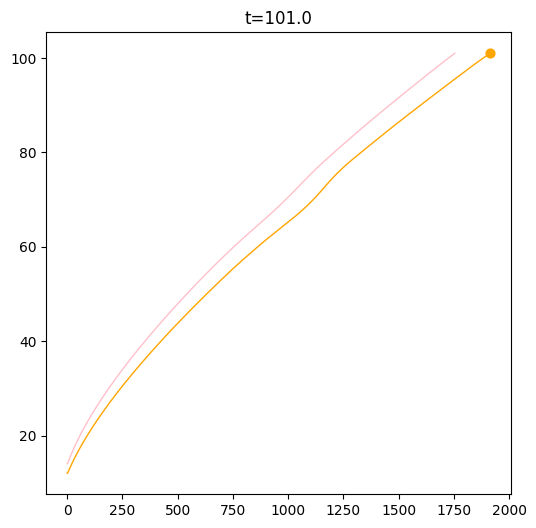

In [7]:
# 同じ条件でVFRをデバッグ
vfr_simulation = VFRSimulation(TOTAL_TIME = 500, TIME_STEP = TIME_STEP, TOTAL_LENGTH = TOTAL_LENGTH, dfr_reference=simulation, car_params=car_params)
vfr_simulation.conduct_simulation(should_plot=True)

In [7]:
print(vfr_simulation.goal_time)
print()
print(vfr_simulation.arrival_time_log)

[67.2, 73.60000000000001, 79.7, 89.60000000000001, 95.0, 100.5, 105.80000000000001, 111.0, 116.0, 121.4, 126.5, 131.6, 136.6, 141.5, 146.20000000000002, 151.9, 156.70000000000002, 161.4, 166.0, 170.70000000000002, 175.3, 179.70000000000002, 184.5, 188.9, 193.3, 197.70000000000002, 202.10000000000002, 206.5, 210.8, 215.4, 219.70000000000002, 224.0, 228.20000000000002, 232.5, 236.70000000000002, 240.9, 245.5, 249.8, 254.0, 258.1, 262.2, 266.3, 270.3, 275.1, 279.40000000000003, 283.6, 287.7, 291.8, 295.90000000000003, 299.90000000000003]

[0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0, 32.0, 34.0, 36.0, 38.0, 40.800000000000004, 43.5, 46.2, 48.900000000000006, 51.6, 54.400000000000006, 57.1, 59.900000000000006, 62.7, 65.60000000000001, 68.4, 71.2, 74.10000000000001, 76.9, 79.80000000000001, 82.60000000000001, 85.5, 88.4, 91.30000000000001, 94.2, 97.10000000000001, 100.10000000000001, 103.0, 105.9, 108.80000000000001, 111.80000000000001, 114.7, 1

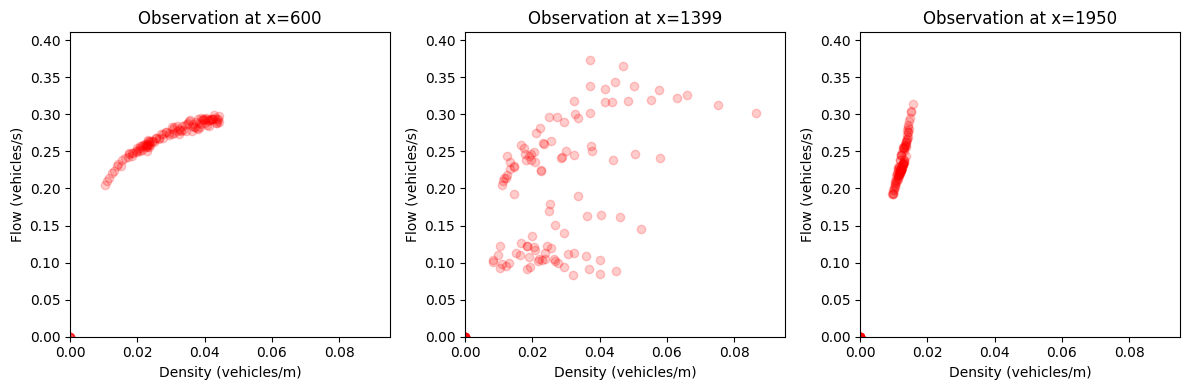

In [9]:
result = vfr_simulation.flow_results
# print(result)
plot_results(result)

In [15]:
cars = simulation.CARS
v_mean_log = simulation.v_mean_log
car_1 = cars[68]
print(v_mean_log[:2])

def draw_fd_before_and_after(v_mean_log, density_increment, xmax=200, ymax=1000):
    src_data = pd.DataFrame(v_mean_log)
    print(src_data.head())
    df = src_data[src_data["time"]%0.5 == 0]
    df_bn = df[df["v_mean_before_noise"] > 0] # df before noise
    df_an = df[df["v_mean_after_noise"] > 0] # df after noise


    # ここから描画開始
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 18))
    
    # 1つ目のグラフ (flow_total vs density)
    # ax1.plot(data['local_density'], data['flow'], marker='s', linestyle='--', color='b')
    ax1.scatter(df['density'], df['flow'], marker='o', color='b', alpha=0.2)

    # 平均線を追加
    density_points = np.arange(0, 800, 5)
    mean_flow = [df[(df['density'] >= d - density_increment) & (df['density'] < d + density_increment)]['flow'].mean()
                 for d in density_points]
    ax1.plot(density_points, mean_flow, color='blue', linestyle='--', linewidth=2, label='Average Flow', alpha=0.4)
    
    ax1.legend()
    ax1.set_title('Flow vs Local Density')
    ax1.set_xlabel('Global Density (vehicles/km)')
    ax1.set_ylabel('Flow (vehicles/s)')
    ax1.set_title('Flow vs Density')
    ax1.grid(True)
    ax1.set_xlim(0, xmax)  # x軸の範囲を設定
    ax1.set_ylim(-10, ymax) 
    
    # 2つ目のグラフ (ノイズ手前)
    ax2.scatter(df_bn['rho_before_noise'], df_bn['flow_before_noise'], marker='s', color='r', alpha=0.2)
    # 平均線を追加
    mean_flow_bn = [df_bn[(df_bn['rho_before_noise'] >= d - density_increment) & (df_bn['rho_before_noise'] < d + density_increment)]['flow_before_noise'].mean()
                 for d in density_points]
    ax2.plot(density_points, mean_flow_bn, color='r', linestyle='--', linewidth=2, label='Average Flow', alpha=0.4)
    
    ax2.set_xlabel('Local Density (vehicles/km)')
    ax2.set_ylabel('Flow')
    ax2.set_title('Flow Before Noise')  
    ax2.grid(True)
    ax2.set_xlim(0, xmax)  # x軸の範囲を設定
    ax2.set_ylim(-10, ymax) 
    

    # 3つ目のグラフ (ノイズ後)
    ax3.scatter(df_an['rho_after_noise'], df_an['flow_after_noise'], marker='s', color='green', alpha=0.2)
    ax3.set_xlabel('Density (vehicles/km)')
    ax3.set_ylabel('Flow')
    ax3.set_title('Flow After Noise')  
    ax3.grid(True)
    ax3.set_xlim(0, xmax)  # x軸の範囲を設定
    ax3.set_ylim(-10, ymax) 
    
    
    
    # レイアウトの調整と表示
    plt.tight_layout()
    plt.show()

draw_fd_before_and_after(v_mean_log, 3, xmax=100, ymax=600)

NameError: name 'simulation' is not defined

In [28]:
a = [{'time': 1.5, 'v_mean': 20.0, 'density': 0.6666666666666666}, {'time': 2.5, 'v_mean': 20.0, 'density': 1.6666666666666666}]
b = a
print(len(a+b))
print(a+b)

cars = simulation.CARS
print(cars[37].my_etas)
print()
print(cars[38].my_etas)

eta_table = simulation.reservation_table
print(eta_table.eta_table)

4
[{'time': 1.5, 'v_mean': 20.0, 'density': 0.6666666666666666}, {'time': 2.5, 'v_mean': 20.0, 'density': 1.6666666666666665}, {'time': 1.5, 'v_mean': 20.0, 'density': 0.6666666666666666}, {'time': 2.5, 'v_mean': 20.0, 'density': 1.6666666666666665}]
[{'waypoint_idx': 0, 'x': 0.0, 'eta': 91.39031681786986, 'car_idx': 37, 'type': 'waypoint'}, {'waypoint_idx': 1, 'x': 150.0, 'eta': 98.89031681786986, 'car_idx': 37, 'type': 'waypoint'}, {'waypoint_idx': 2, 'x': 300.0, 'eta': 106.39031681786986, 'car_idx': 37, 'type': 'waypoint'}, {'waypoint_idx': 3, 'x': 450.0, 'eta': 113.89031681786986, 'car_idx': 37, 'type': 'waypoint'}, {'waypoint_idx': 4, 'x': 600.0, 'eta': 121.39031681786986, 'car_idx': 37, 'type': 'waypoint'}, {'waypoint_idx': 5, 'x': 750.0, 'eta': 128.89031681786986, 'car_idx': 37, 'type': 'waypoint'}, {'waypoint_idx': 6, 'x': 900.0, 'eta': 136.39031681786986, 'car_idx': 37, 'type': 'waypoint'}, {'waypoint_idx': 7, 'x': 1050.0, 'eta': 143.89031681786986, 'car_idx': 37, 'type': 'way

### まとめてシミュレーションするコード（流量のプロットは各シミュレーションにおいて一回だけ）

In [12]:
# VFRのFlowの図を作る

def register_initial_eta(cars, eta_table, waypoints):
    for idx, car in enumerate(cars):
        desired_eta_list = car.create_desired_eta(waypoints)
        is_valid = eta_table.validate(desired_eta_list)
        if is_valid:
            eta_table.register(desired_eta_list)
        else:
            calibration_info = {"desired_list": desired_eta_list}
            calibrated_list, _ = eta_table.calibrate_list(**calibration_info)
            # print(calibrated_list)
            # print()
            eta_table.register(calibrated_list)
            car.my_list = calibrated_list


def conduct_parametric_study(**kwargs):
    density_list = arithmetic_sequence(0.05, 0.05, 10)
    DFR_LAMBDA_LIST = [10, 5, 4, 2.5, 2.22, 2]
    
    arrival_time_log = []
    WAYPOINTS_NUM = 10 #constrained way pointの数
    TOTAL_LENGTH = 2000 # 入り口から出口までの距離 [m]
    WAYPOINTS = [{"waypoint_idx": i, "x": TOTAL_LENGTH / WAYPOINTS_NUM * (i)} for i in range(WAYPOINTS_NUM+1)]
    LAMBDA_LIST = [1/d for d in density_list ]
    # LAMBDA_LIST = [10,  2]
    # LAMBDA_LIST = [2.4]
    NOISE_START = 1300
    NOISE_FORECAST_TIME_LIST = [16]
    NOISE_PERIOD_LIST = [2]
    # COMMU_SPEED_LIST = [0.1, 0.2, 0.6, 1]
    TTC_LIST = [2]
    # TTC_LIST = [2.0]
    COMMU_SPEED_LIST = [0.2]
    v_mean_log_dfr = []
    v_mean_log_vfr = []
    # TTC = 1.5
    CAR_NUM = 300
    NOISE_FREQUENCY_LIST = [18]

    # ログ用の変数
    log_interval = kwargs.get("log_interval", 0.5)
    goal_time_dict = []
    
    total_iterations = len(NOISE_FORECAST_TIME_LIST) * len(NOISE_PERIOD_LIST) * len(COMMU_SPEED_LIST) * len(LAMBDA_LIST) * len(NOISE_FREQUENCY_LIST) * len(TTC_LIST)
    with tqdm(total=total_iterations) as pbar:
        for noise_forecast_time in NOISE_FORECAST_TIME_LIST:
            for noise_period in NOISE_PERIOD_LIST:
                for noise_frequency in NOISE_FREQUENCY_LIST:
                    for communication_speed in COMMU_SPEED_LIST:
                        for TTC in TTC_LIST:
                            for idx, LAMBDA in enumerate(LAMBDA_LIST):
                                
                                def create_noise(current_time):
                                    if current_time % noise_frequency == 0 and current_time > 0:
                                        # print(f"===current_time:{current_time},noise_freq={noise_frequency} %={current_time%noise_frequency}")
                                        # ノイズを未来に発生させる（この瞬間、だと偶然ハマる車が出てきしまう）
                                        return {"x": [NOISE_START, NOISE_START+20], "t": [current_time + noise_forecast_time, current_time + noise_forecast_time + noise_period]}
                                    # この場合はノイズを発生させない.
                                    return None
                                    
                                print(f"Running simulation with LAMBDA={LAMBDA}, noise_forecast_time={noise_forecast_time}, noise_period={noise_period}, communication_speed={communication_speed}, TTC={TTC}, noise_freq={noise_frequency}")
                            
                                # arrival_times = generate_arrival_times_poisson(LAMBDA, TTC, CAR_NUM)
                                arrival_times = create_arrival_times_arithmetic_seq(LAMBDA, CAR_NUM)
                                CARS = [Cars(arrival_time=time, index=index, v_mean=MEAN_SPEED, v_max = MAX_SPEED, a_max=MAX_ACC, a_min=MAX_ACC)
                                          for index, time in enumerate(arrival_times)]
                                TOTAL_TIME = min(arrival_times[-1]-1, 800)
        
                                eta_table = ReservationTable(waypoints = WAYPOINTS, global_params = {"DESIRED_TTC":TTC})
                                register_initial_eta(CARS, eta_table, WAYPOINTS)
    
                                try:
                                    dfr_simulation = DFRSimulation(TOTAL_TIME = TOTAL_TIME, TIME_STEP = TIME_STEP, TOTAL_LENGTH = TOTAL_LENGTH, CARS = CARS, \
                                                          reservation_table = eta_table, DENSITY=LAMBDA, COMMUNICATION_SPEED=communication_speed, create_noise=create_noise)
                                    if any(abs(LAMBDA - dfr_lambda) <= 0.01 for dfr_lambda in DFR_LAMBDA_LIST):
                                        dfr_simulation.conduct_simulation(should_plot=False)
                                        v_mean_log = [{"is_success": True,"noise_forecast_time":noise_forecast_time, "noise_period":noise_period, "communication_speed":communication_speed,"TTC":TTC, "lambda": LAMBDA,"NOISE_FREQUENCY":noise_frequency, **log} for log in dfr_simulation.v_mean_log if log["time"] % log_interval == 0]
                                        v_mean_log_dfr += v_mean_log
                                        arrival_time_log.append({"lambda": LAMBDA, "arrival_times":arrival_times, "noise_forecast_time":noise_forecast_time, "noise_period":noise_period, "communication_speed":communication_speed,"TTC":TTC,"NOISE_FREQUENCY":noise_frequency, "is_success":True})
                                        goal_time_dict.append({
                                                'noise_forecast_time': noise_forecast_time,
                                                'noise_period': noise_period,
                                                'noise_frequency': noise_frequency,
                                                'communication_speed': communication_speed,
                                                'TTC': TTC,
                                                'LAMBDA': LAMBDA,
                                                'goal_times': dfr_simulation.goal_time,
                                                "flight":"dfr",
                                            })
        
        
                                except Exception as e:
                                    print("DFR simulation failed:", e)
                                    goal_time_dict.append({
                                            'noise_forecast_time': noise_forecast_time,
                                            'noise_period': noise_period,
                                            'noise_frequency': noise_frequency,
                                            'communication_speed': communication_speed,
                                            'TTC': TTC,
                                            'LAMBDA': LAMBDA,
                                            'goal_times': dfr_simulation.goal_time,
                                            "effective_lambda":effective_lambda,
                                            "flight":"dfr",
                                        })
                                    # print({"is_success": False, "details": str(e),"noise_forecast_time":noise_forecast_time, "noise_period":noise_period, "communication_speed":communication_speed, "TTC":TTC, "lambda": LAMBDA})
                                    # v_mean_log = [{"is_success": False, "details": str(e),"noise_forecast_time":noise_forecast_time, "noise_period":noise_period, "communication_speed":communication_speed, "lambda": LAMBDA,"TTC":TTC,"NOISE_FREQUENCY":noise_frequency, **log} for log in dfr_simulation.v_mean_log  if log["time"] % log_interval == 0]
                                    # v_mean_log_dfr += v_mean_log
                                    # arrival_time_log.append({"lambda": LAMBDA, "arrival_times":arrival_times, "noise_forecast_time":noise_forecast_time, "noise_period":noise_period, "communication_speed":communication_speed, "TTC":TTC,"NOISE_FREQUENCY":noise_frequency, "is_success":False})
        
    
                                try:
                                    print("conducting vfr")
                                    
                                    vfr_simulation = VFRSimulation(TOTAL_TIME = TOTAL_TIME, TIME_STEP = TIME_STEP, TOTAL_LENGTH = TOTAL_LENGTH, dfr_reference=dfr_simulation, car_params=car_params)
                                    vfr_simulation.conduct_simulation(should_plot=False)
                                    v_mean_log = [{"noise_forecast_time":noise_forecast_time, "noise_period":noise_period,"NOISE_FREQUENCY":noise_frequency, "is_success": True, **log} for log in vfr_simulation.v_mean_log if log["time"] % log_interval == 0]
                                    v_mean_log_vfr += v_mean_log
                                    arrival_time_log = vfr_simulation.arrival_time_log
                                    effective_lambda = arrival_time_log[-1] / len(arrival_time_log)
                                    goal_time_dict.append({
                                            'noise_forecast_time': noise_forecast_time,
                                            'noise_period': noise_period,
                                            'noise_frequency': noise_frequency,
                                            'communication_speed': communication_speed,
                                            'TTC': TTC,
                                            'LAMBDA': LAMBDA,
                                            'goal_times': vfr_simulation.goal_time,
                                            "flight":"vfr",
                                            "effective_lambda":effective_lambda
                                        })

                                except Exception as e:
                                    print("VFR simulation failed:", e)
                                    print({"is_success": False, "details": str(e),"noise_forecast_time":noise_forecast_time, "noise_period":noise_period, "communication_speed":communication_speed, "lambda": LAMBDA})
                                    arrival_time_log = vfr_simulation.arrival_time_log
                                    effective_lambda = arrival_time_log[-1] / len(arrival_time_log)
                                    goal_time_dict.append({
                                            'noise_forecast_time': noise_forecast_time,
                                            'noise_period': noise_period,
                                            'noise_frequency': noise_frequency,
                                            'communication_speed': communication_speed,
                                            'TTC': TTC,
                                            'LAMBDA': LAMBDA,
                                            'goal_times': vfr_simulation.goal_time,
                                            "flight":"vfr",
                                            "effective_lambda":effective_lambda
                                        })
                                pbar.update(1)
                        
    return v_mean_log_dfr, v_mean_log_vfr, arrival_time_log, goal_time_dict


v_mean_log_dfr ,v_mean_log_vfr, arrival_time_log, goal_time_dict = conduct_parametric_study()


  0%|          | 0/10 [00:00<?, ?it/s]

Running simulation with LAMBDA=20.0, noise_forecast_time=16, noise_period=2, communication_speed=0.2, TTC=2, noise_freq=18
conducting vfr


Simulation Progress VFR:   0%|          | 0/8000 [00:00<?, ?it/s]

Running simulation with LAMBDA=10.0, noise_forecast_time=16, noise_period=2, communication_speed=0.2, TTC=2, noise_freq=18


Simulation Progress DFR, density=10.0:   0%|          | 0/8000 [00:00<?, ?it/s]

conducting vfr


Simulation Progress VFR:   0%|          | 0/8000 [00:00<?, ?it/s]

Running simulation with LAMBDA=6.666666666666666, noise_forecast_time=16, noise_period=2, communication_speed=0.2, TTC=2, noise_freq=18
conducting vfr


Simulation Progress VFR:   0%|          | 0/8000 [00:00<?, ?it/s]

Running simulation with LAMBDA=5.0, noise_forecast_time=16, noise_period=2, communication_speed=0.2, TTC=2, noise_freq=18


Simulation Progress DFR, density=5.0:   0%|          | 0/8000 [00:00<?, ?it/s]

=====入った=====
    waypoint_idx       x         eta  car_idx      type
0            0.0     0.0  200.000000       40  waypoint
1            1.0   200.0  210.000000       40  waypoint
2            2.0   400.0  220.000000       40  waypoint
3            3.0   600.0  230.000000       40  waypoint
4            4.0   800.0  239.433326       40  waypoint
5            5.0  1000.0  247.766624       40  waypoint
6            6.0  1200.0  256.099923       40  waypoint
7            7.0  1400.0  264.433222       40  waypoint
8            8.0  1600.0  272.766520       40  waypoint
9            9.0  1800.0  281.099826       40  waypoint
10          10.0  2000.0  289.298325       40  waypoint
11           NaN  1300.0  260.266572       40     noise
12           NaN  1320.0  261.099902       40     noise [{'t_start': 235.9, 'acc': 0, 'x_start': 618.0, 'v_0': 20.0, 't_end': 235.9}, {'t_start': 235.9, 'acc': 2, 'x_start': 618.0, 'v_0': 20.0, 't_end': 238.3}, {'t_start': 238.3, 'acc': 0, 'v_0': 24.8, 't_en

Simulation Progress VFR:   0%|          | 0/8000 [00:00<?, ?it/s]

Running simulation with LAMBDA=4.0, noise_forecast_time=16, noise_period=2, communication_speed=0.2, TTC=2, noise_freq=18


Simulation Progress DFR, density=4.0:   0%|          | 0/8000 [00:00<?, ?it/s]

conducting vfr


Simulation Progress VFR:   0%|          | 0/8000 [00:00<?, ?it/s]

Running simulation with LAMBDA=3.3333333333333335, noise_forecast_time=16, noise_period=2, communication_speed=0.2, TTC=2, noise_freq=18
conducting vfr


Simulation Progress VFR:   0%|          | 0/8000 [00:00<?, ?it/s]

Running simulation with LAMBDA=2.8571428571428568, noise_forecast_time=16, noise_period=2, communication_speed=0.2, TTC=2, noise_freq=18
conducting vfr


Simulation Progress VFR:   0%|          | 0/8000 [00:00<?, ?it/s]

Running simulation with LAMBDA=2.5, noise_forecast_time=16, noise_period=2, communication_speed=0.2, TTC=2, noise_freq=18


Simulation Progress DFR, density=2.5:   0%|          | 0/7465 [00:00<?, ?it/s]

=====入った=====
         waypoint_idx       x         eta  car_idx      type
car_idx                                                     
40                0.0     0.0  100.000000       40  waypoint
40                1.0   200.0  110.000000       40  waypoint
40                2.0   400.0  120.000000       40  waypoint
40                3.0   600.0  130.000000       40  waypoint
40                4.0   800.0  140.000000       40  waypoint
40                5.0  1000.0  149.747541       40  waypoint
40                6.0  1200.0  157.263935       40  waypoint
40                7.0  1400.0  164.673230       40  waypoint
40                8.0  1600.0  172.026144       40  waypoint
40                9.0  1800.0  179.379059       40  waypoint
40               10.0  2000.0  186.731973       40  waypoint
40                NaN  1300.0  160.995288       40     noise
40                NaN  1320.0  161.732065       40     noise [{'t_start': 150.0, 'acc': 0, 'x_start': 950.0, 'v_0': 20.0, 't_end': 1

Simulation Progress VFR:   0%|          | 0/7465 [00:00<?, ?it/s]

Running simulation with LAMBDA=2.2222222222222223, noise_forecast_time=16, noise_period=2, communication_speed=0.2, TTC=2, noise_freq=18


Simulation Progress DFR, density=2.2222222222222223:   0%|          | 0/6634 [00:00<?, ?it/s]

car_plan_by_x: {'waypoint_idx': 2, 'x': 400.0, 'eta': 111.11111111111111, 'car_idx': 41, 'type': 'waypoint'}
TTC: 2
max_eta_by_wp: x
0.0        88.888889
200.0      99.690540
400.0     111.433186
600.0     123.761012
800.0     136.106951
1000.0    148.452889
1200.0    160.798828
1300.0    166.691001
1320.0    167.796318
1400.0    171.844875
1600.0    179.614782
1800.0    186.439367
2000.0    193.242167
Name: eta, dtype: float64

car_plans: [{'waypoint_idx': 0, 'x': 0.0, 'eta': 91.11111111111111, 'car_idx': 41, 'type': 'waypoint'}, {'waypoint_idx': 1, 'x': 200.0, 'eta': 101.11111111111111, 'car_idx': 41, 'type': 'waypoint'}, {'waypoint_idx': 2, 'x': 400.0, 'eta': 111.11111111111111, 'car_idx': 41, 'type': 'waypoint'}, {'waypoint_idx': 3, 'x': 600.0, 'eta': 121.11111111111111, 'car_idx': 41, 'type': 'waypoint'}, {'waypoint_idx': 4, 'x': 800.0, 'eta': 131.11111111111111, 'car_idx': 41, 'type': 'waypoint'}, {'waypoint_idx': 5, 'x': 1000.0, 'eta': 141.11111111111111, 'car_idx': 41, 'type': 

Simulation Progress VFR:   0%|          | 0/6634 [00:00<?, ?it/s]

Running simulation with LAMBDA=2.0, noise_forecast_time=16, noise_period=2, communication_speed=0.2, TTC=2, noise_freq=18


Simulation Progress DFR, density=2.0:   0%|          | 0/5970 [00:00<?, ?it/s]

car_plan_by_x: {'waypoint_idx': 5, 'x': 1000.0, 'eta': 142.63238059390343, 'car_idx': 41, 'type': 'waypoint'}
TTC: 2
max_eta_by_wp: x
0.0        80.000000
200.0      93.166656
400.0     105.834943
600.0     118.183092
800.0     129.455011
1000.0    140.797657
1200.0    155.083373
1300.0    160.289932
1320.0    161.085243
1400.0    164.049942
1600.0    171.198497
1800.0    178.341353
2000.0    185.385016
Name: eta, dtype: float64

car_plans: [{'waypoint_idx': 0, 'x': 0.0, 'eta': 82.0, 'car_idx': 41, 'type': 'waypoint'}, {'waypoint_idx': 1, 'x': 200.0, 'eta': 97.5499817333902, 'car_idx': 41, 'type': 'waypoint'}, {'waypoint_idx': 2, 'x': 400.0, 'eta': 109.23129925886307, 'car_idx': 41, 'type': 'waypoint'}, {'waypoint_idx': 3, 'x': 600.0, 'eta': 120.53072175573503, 'car_idx': 41, 'type': 'waypoint'}, {'waypoint_idx': 4, 'x': 800.0, 'eta': 131.58265792940915, 'car_idx': 41, 'type': 'waypoint'}, {'waypoint_idx': 5, 'x': 1000.0, 'eta': 142.63238059390343, 'car_idx': 41, 'type': 'waypoint'}, {

Simulation Progress VFR:   0%|          | 0/5970 [00:00<?, ?it/s]

===該当なし====
{'noise_forecast_time': 16, 'noise_period': 2, 'noise_frequency': 18, 'communication_speed': 0.2, 'TTC': 2, 'LAMBDA': 2.2222222222222223, 'goal_times': [99.9, 102.2, 104.30000000000001, 106.4, 108.60000000000001, 110.80000000000001], 'effective_lambda': 3.0101214574898787, 'flight': 'dfr'}
[{'noise_forecast_time': 16, 'noise_period': 2, 'noise_frequency': 18, 'communication_speed': 0.2, 'TTC': 2, 'LAMBDA': 20.0, 'goal_times_over_thresh': 25, 'flow': 0.05137690094533497, 'flight': 'vfr', 'effective_lambda': 19.5}, {'noise_forecast_time': 16, 'noise_period': 2, 'noise_frequency': 18, 'communication_speed': 0.2, 'TTC': 2, 'LAMBDA': 10.0, 'goal_times_over_thresh': 52, 'flow': 0.10519927169734977, 'flight': 'dfr', 'effective_lambda': 10.0}, {'noise_forecast_time': 16, 'noise_period': 2, 'noise_frequency': 18, 'communication_speed': 0.2, 'TTC': 2, 'LAMBDA': 10.0, 'goal_times_over_thresh': 50, 'flow': 0.10068465565847765, 'flight': 'vfr', 'effective_lambda': 9.875}, {'noise_foreca

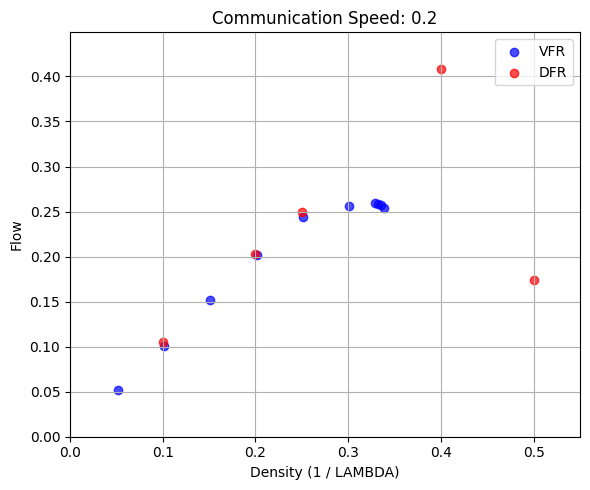

In [13]:
goal_thersh=300

def calc_flow_by_goal_time(goal_time_dict, goal_thresh=200):
    result = []
    for goalObj in goal_time_dict:
        filtered_goal_times = [t for t in goalObj["goal_times"] if t > goal_thresh]
        if len(filtered_goal_times) < 1:
            print("===該当なし====")
            print(goalObj)
            print("=======")
            
        else:
            result.append({
                'noise_forecast_time': goalObj['noise_forecast_time'],
                'noise_period': goalObj['noise_period'],
                'noise_frequency': goalObj['noise_frequency'],
                'communication_speed': goalObj['communication_speed'],
                'TTC': goalObj['TTC'],
                'LAMBDA': goalObj['LAMBDA'],
                'goal_times_over_thresh': len(filtered_goal_times),  # goal_thresh超えの数
                "flow":len(filtered_goal_times) / (filtered_goal_times[-1] -  goal_thresh),
                "flight":goalObj['flight'],
                "effective_lambda": goalObj.get('effective_lambda', goalObj['LAMBDA'])
            })
    return result
    
result = calc_flow_by_goal_time(goal_time_dict, goal_thersh)
print(result)

def plot_flow_vs_density(results, split_by_communication_speed=False):
    """
    Lambdaの逆数 (Density) を横軸、Flowを縦軸に、flightごとに色分けしたグラフを作成する関数

    Parameters
    ----------
    results : list of dict
        calc_flow_by_goal_timeの出力結果。
    split_by_communication_speed : bool, optional
        Trueの場合、communication_speedごとにグラフを分割（デフォルトはFalse）


    解釈
    Flow: １秒あたりにゴールする車の数
    Density: 流入レート, 1秒あたりにコースに入ってくる車の数. 
    """

    # flightごとの色を指定
    flight_colors = {
        "vfr": "blue",
        "dfr": "red"
    }

    # communication_speedの値を抽出（重複なし）
    comm_speeds = sorted(set(item["communication_speed"] for item in results))

    # グラフの分割方法
    n_cols = len(comm_speeds) if split_by_communication_speed else 1
    n_rows = 1

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5))
    if n_cols == 1:
        axes = [axes]  # サブプロットが1つのときもリストに

    # DensityとFlowの全体的な最大値を取得
    all_density = [1 / item["effective_lambda"] for item in results if item["effective_lambda"] != 0]
    all_flow = [item["flow"] for item in results]

    max_density = max(all_density) * 1.1  # 最大密度の1.05倍
    max_flow = max(all_flow) * 1.1        # 最大流量の1.1倍
    print(all_density)

    for idx, comm_speed in enumerate(comm_speeds):
        ax = axes[idx]

        # 該当のcommunication_speedのデータを抽出
        filtered_results = [item for item in results if item["communication_speed"] == comm_speed]

        # flightごとにプロット
        for flight in ["vfr", "dfr"]:
            # flightに対応するデータを抽出
            flight_data = [item for item in filtered_results if item["flight"] == flight]

            # Density（1 / LAMBDA）とFlowを抽出
            density = [1 / item["effective_lambda"] for item in flight_data if item["effective_lambda"] != 0]
            flow = [item["flow"] for item in flight_data]

            # プロット
            ax.scatter(density, flow, label=f"{flight.upper()}", color=flight_colors.get(flight, "gray"), alpha=0.7)

        # 軸ラベル・タイトル
        ax.set_xlabel("Density (1 / LAMBDA)")
        ax.set_ylabel("Flow")
        ax.set_title(f"Communication Speed: {comm_speed}")
        ax.legend()
        ax.grid(True)
        ax.set_xlim(0, max_density)  # 最大値の1.05倍まで
        ax.set_ylim(0, max_flow)    

    plt.tight_layout()
    plt.show()

plot_flow_vs_density(result)

In [43]:
def describe(idx):
    obj = goal_time_dict[idx]
    print(f"密度: {obj["LAMBDA"]}, 長さ: {len(obj["goal_times"])}, 詳細:{obj}")
    print()
# describe(0)
# describe(8)
describe(10)

密度: 1, 長さ: 51, 詳細:{'noise_forecast_time': 16, 'noise_period': 2, 'noise_frequency': 20, 'communication_speed': 0.2, 'TTC': 2, 'LAMBDA': 1, 'goal_times': [67.2, 73.5, 84.7, 90.10000000000001, 95.4, 100.4, 106.10000000000001, 111.30000000000001, 116.30000000000001, 121.2, 126.7, 131.6, 136.5, 141.1, 147.1, 151.70000000000002, 156.3, 160.9, 165.20000000000002, 169.9, 174.3, 178.60000000000002, 183.0, 187.20000000000002, 191.60000000000002, 195.8, 200.0, 204.20000000000002, 208.4, 212.60000000000002, 216.70000000000002, 220.8, 224.9, 229.0, 233.20000000000002, 237.3, 241.3, 245.4, 249.4, 253.60000000000002, 257.6, 261.6, 265.6, 269.6, 273.7, 277.7, 281.7, 285.6, 289.5, 293.7, 297.7], 'flight': 'vfr'}



### まとめてシミュレーションするためのコード（2024年ver）


In [65]:
arithmetic_sequence(0.05, 0.05, 10)

[0.05,
 0.1,
 0.15000000000000002,
 0.2,
 0.25,
 0.3,
 0.35000000000000003,
 0.4,
 0.45,
 0.5]

In [20]:
print(result)

[{'noise_forecast_time': 16, 'noise_period': 2, 'noise_frequency': 15, 'communication_speed': 0.2, 'TTC': 2, 'LAMBDA': 10, 'goal_times_over_thresh': 60, 'flow': 0.10046885465505692, 'flight': 'vfr'}, {'noise_forecast_time': 16, 'noise_period': 2, 'noise_frequency': 15, 'communication_speed': 0.2, 'TTC': 2, 'LAMBDA': 9, 'goal_times_over_thresh': 67, 'flow': 0.11237839651123784, 'flight': 'vfr'}, {'noise_forecast_time': 16, 'noise_period': 2, 'noise_frequency': 15, 'communication_speed': 0.2, 'TTC': 2, 'LAMBDA': 8, 'goal_times_over_thresh': 75, 'flow': 0.12600806451612903, 'flight': 'vfr'}, {'noise_forecast_time': 16, 'noise_period': 2, 'noise_frequency': 15, 'communication_speed': 0.2, 'TTC': 2, 'LAMBDA': 6, 'goal_times_over_thresh': 100, 'flow': 0.16702856188408216, 'flight': 'vfr'}, {'noise_forecast_time': 16, 'noise_period': 2, 'noise_frequency': 15, 'communication_speed': 0.2, 'TTC': 2, 'LAMBDA': 5, 'goal_times_over_thresh': 120, 'flow': 0.20060180541624872, 'flight': 'vfr'}, {'nois

In [6]:

def register_initial_eta(cars, eta_table, waypoints):
    for idx, car in enumerate(cars):
        desired_eta_list = car.create_desired_eta(waypoints)
        is_valid = eta_table.validate(desired_eta_list)
        if is_valid:
            eta_table.register(desired_eta_list)
        else:
            calibration_info = {"desired_list": desired_eta_list}
            calibrated_list, _ = eta_table.calibrate_list(**calibration_info)
            # print(calibrated_list)
            # print()
            eta_table.register(calibrated_list)
            car.my_list = calibrated_list


def conduct_parametric_study(**kwargs):
    arrival_time_log = []
    WAYPOINTS_NUM = 10 #constrained way pointの数
    TOTAL_LENGTH = 2000 # 入り口から出口までの距離 [m]
    WAYPOINTS = [{"waypoint_idx": i, "x": TOTAL_LENGTH / WAYPOINTS_NUM * (i)} for i in range(WAYPOINTS_NUM+1)]
    LAMBDA_LIST = [4.01, 1.6]
    # LAMBDA_LIST = [2.4]
    NOISE_START = 1300
    NOISE_FORECAST_TIME_LIST = [12]
    NOISE_PERIOD_LIST = [2]
    # COMMU_SPEED_LIST = [0.1, 0.2, 0.6, 1]
    TTC_LIST = [2]
    # TTC_LIST = [2.0]
    COMMU_SPEED_LIST = [0.2]
    v_mean_log_dfr = []
    v_mean_log_vfr = []
    # TTC = 1.5
    CAR_NUM = 200
    NOISE_FREQUENCY_LIST = [15]

    # ログ用の変数
    log_interval = kwargs.get("log_interval", 0.5)
    
    
    total_iterations = len(NOISE_FORECAST_TIME_LIST) * len(NOISE_PERIOD_LIST) * len(COMMU_SPEED_LIST) * len(LAMBDA_LIST) * len(NOISE_FREQUENCY_LIST) * len(TTC_LIST)
    with tqdm(total=total_iterations) as pbar:
        for noise_forecast_time in NOISE_FORECAST_TIME_LIST:
            for noise_period in NOISE_PERIOD_LIST:
                for noise_frequency in NOISE_FREQUENCY_LIST:
                    for communication_speed in COMMU_SPEED_LIST:
                        for TTC in TTC_LIST:
                            for idx, LAMBDA in enumerate(LAMBDA_LIST):
                                
                                def create_noise(current_time):
                                    if current_time % noise_frequency == 0 and current_time > 0:
                                        # print(f"===current_time:{current_time},noise_freq={noise_frequency} %={current_time%noise_frequency}")
                                        # ノイズを未来に発生させる（この瞬間、だと偶然ハマる車が出てきしまう）
                                        return {"x": [NOISE_START, NOISE_START+20], "t": [current_time + noise_forecast_time, current_time + noise_forecast_time + noise_period]}
                                    # この場合はノイズを発生させない.
                                    return None
                                    
                                print(f"Running simulation with LAMBDA={LAMBDA}, noise_forecast_time={noise_forecast_time}, noise_period={noise_period}, communication_speed={communication_speed}, TTC={TTC}, noise_freq={noise_frequency}")
                            
                                arrival_times = generate_arrival_times_poisson(LAMBDA, TTC, CAR_NUM)
                                CARS = [Cars(arrival_time=time, index=index, v_mean=MEAN_SPEED, v_max = MAX_SPEED, a_max=MAX_ACC, a_min=MAX_ACC)
                                          for index, time in enumerate(arrival_times)]
                                TOTAL_TIME = min(arrival_times[-1]-1, 400)
        
                                eta_table = ReservationTable(waypoints = WAYPOINTS, global_params = {"DESIRED_TTC":TTC})
                                register_initial_eta(CARS, eta_table, WAYPOINTS)
    
                                try:
                                    dfr_simulation = DFRSimulation(TOTAL_TIME = TOTAL_TIME, TIME_STEP = TIME_STEP, TOTAL_LENGTH = TOTAL_LENGTH, CARS = CARS, \
                                                          reservation_table = eta_table, DENSITY=LAMBDA, COMMUNICATION_SPEED=communication_speed, create_noise=create_noise)
                                    dfr_simulation.conduct_simulation(should_plot=False)
                                    v_mean_log = [{"is_success": True,"noise_forecast_time":noise_forecast_time, "noise_period":noise_period, "communication_speed":communication_speed,"TTC":TTC, "lambda": LAMBDA,"NOISE_FREQUENCY":noise_frequency, **log} for log in dfr_simulation.v_mean_log if log["time"] % log_interval == 0]
                                    v_mean_log_dfr += v_mean_log
                                    arrival_time_log.append({"lambda": LAMBDA, "arrival_times":arrival_times, "noise_forecast_time":noise_forecast_time, "noise_period":noise_period, "communication_speed":communication_speed,"TTC":TTC,"NOISE_FREQUENCY":noise_frequency, "is_success":True})
        
        
                                except Exception as e:
                                    print("DFR simulation failed:", e)
                                    print({"is_success": False, "details": str(e),"noise_forecast_time":noise_forecast_time, "noise_period":noise_period, "communication_speed":communication_speed, "TTC":TTC, "lambda": LAMBDA})
                                    v_mean_log = [{"is_success": False, "details": str(e),"noise_forecast_time":noise_forecast_time, "noise_period":noise_period, "communication_speed":communication_speed, "lambda": LAMBDA,"TTC":TTC,"NOISE_FREQUENCY":noise_frequency, **log} for log in dfr_simulation.v_mean_log  if log["time"] % log_interval == 0]
                                    v_mean_log_dfr += v_mean_log
                                    arrival_time_log.append({"lambda": LAMBDA, "arrival_times":arrival_times, "noise_forecast_time":noise_forecast_time, "noise_period":noise_period, "communication_speed":communication_speed, "TTC":TTC,"NOISE_FREQUENCY":noise_frequency, "is_success":False})
        
    
                                try:
                                    print("conducting vfr")
                                    vfr_simulation = VFRSimulation(TOTAL_TIME = TOTAL_TIME, TIME_STEP = TIME_STEP, TOTAL_LENGTH = TOTAL_LENGTH, dfr_reference=dfr_simulation, car_params=car_params)
                                    vfr_simulation.conduct_simulation(should_plot=False)
                                    v_mean_log = [{"noise_forecast_time":noise_forecast_time, "noise_period":noise_period,"NOISE_FREQUENCY":noise_frequency, "is_success": True, **log} for log in vfr_simulation.v_mean_log if log["time"] % log_interval == 0]
                                    v_mean_log_vfr += v_mean_log
                                    
                                except Exception as e:
                                    print("VFR simulation failed:", e)
                                    print({"is_success": False, "details": str(e),"noise_forecast_time":noise_forecast_time, "noise_period":noise_period, "communication_speed":communication_speed, "lambda": LAMBDA})
                                    v_mean_log = [{"noise_forecast_time":noise_forecast_time, "noise_period":noise_period,"NOISE_FREQUENCY":noise_frequency, "is_success": False, "details": str(e), "lambda": LAMBDA, **log} for log in vfr_simulation.v_mean_log  if log["time"] % log_interval == 0]
                                    v_mean_log_vfr += v_mean_log
                                pbar.update(1)
                        
    return v_mean_log_dfr, v_mean_log_vfr, arrival_time_log


v_mean_log_dfr ,v_mean_log_vfr, arrival_time_log = conduct_parametric_study()

  0%|          | 0/2 [00:00<?, ?it/s]

Running simulation with LAMBDA=4.01, noise_forecast_time=12, noise_period=2, communication_speed=0.2, TTC=2, noise_freq=15


Simulation Progress DFR, density=4.01:   0%|          | 0/4000 [00:00<?, ?it/s]

conducting vfr
VFR simulation failed: 'NoneType' object is not iterable
{'is_success': False, 'details': "'NoneType' object is not iterable", 'noise_forecast_time': 12, 'noise_period': 2, 'communication_speed': 0.2, 'lambda': 4.01}


UnboundLocalError: cannot access local variable 'vfr_simulation' where it is not associated with a value

In [27]:
print(arrival_time_log[2])

{'lambda': 1.6, 'arrival_times': [1.6, 3.2, 4.800000000000001, 8.396936408461803, 11.8540485060988, 13.4540485060988, 15.06685102683918, 16.66685102683918, 18.26685102683918, 20.018572025428426, 22.290238477782523, 23.890238477782525, 25.490238477782526, 27.138468980945227, 29.197871025148068, 30.79787102514807, 32.39787102514807, 35.41468821009049, 37.67789113850247, 39.27789113850247, 40.87789113850247, 43.46474931422448, 45.06474931422448, 46.66474931422448, 48.28990635956764, 50.7234529379288, 52.3234529379288, 53.9234529379288, 55.5234529379288, 57.1234529379288, 58.96631300610597, 60.84992369554081, 62.5869877134747, 64.70584818346386, 66.96501090880531, 69.47921401304083, 71.07921401304083, 72.67921401304082, 74.77107035817527, 76.37107035817526, 77.97107035817525, 80.12225279100491, 81.7222527910049, 83.69207796348472, 85.29207796348472, 86.89207796348471, 88.93173350218592, 90.53173350218592, 92.13173350218591, 93.7317335021859, 95.3317335021859, 96.93173350218589, 99.16264140

In [26]:
# シミュレーションが済んだらひとまず結果を保存. 
import os
import json
import pandas as pd
from datetime import datetime

def save_simulation_logs(v_mean_log_dfr, v_mean_log_vfr, arrival_time_log):
    # 現在時刻をフォルダ名として使用
    current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_folder = f"./{current_time}"
    os.makedirs(save_folder, exist_ok=True)
    
    # v_mean_log_dfr を保存
    if v_mean_log_dfr:
        dfr_df = pd.DataFrame(v_mean_log_dfr)
        dfr_csv_path = os.path.join(save_folder, "v_mean_log_dfr.csv")
        dfr_df.to_csv(dfr_csv_path, index=False)
        print(f"v_mean_log_dfr saved to {dfr_csv_path}")
    else:
        print("v_mean_log_dfr is empty, skipping save.")

    # v_mean_log_vfr を保存
    if v_mean_log_vfr:
        vfr_df = pd.DataFrame(v_mean_log_vfr)
        vfr_csv_path = os.path.join(save_folder, "v_mean_log_vfr.csv")
        vfr_df.to_csv(vfr_csv_path, index=False)
        print(f"v_mean_log_vfr saved to {vfr_csv_path}")
    else:
        print("v_mean_log_vfr is empty, skipping save.")

    # arrival_time_log を保存
    if arrival_time_log:
        arrival_json_path = os.path.join(save_folder, "arrival_time_log.json")
        with open(arrival_json_path, "w") as json_file:
            json.dump(arrival_time_log, json_file, indent=4)
        print(f"arrival_time_log saved to {arrival_json_path}")
    else:
        print("arrival_time_log is empty, skipping save.")

    # 最後にシミュレーションパラメータを保存する. 
    

# 使用例
# v_mean_log_dfr, v_mean_log_vfr, arrival_time_log = conduct_parametric_study()
save_simulation_logs(v_mean_log_dfr, v_mean_log_vfr, arrival_time_log)


v_mean_log_dfr saved to ./20241213_115228/v_mean_log_dfr.csv
v_mean_log_vfr saved to ./20241213_115228/v_mean_log_vfr.csv
arrival_time_log saved to ./20241213_115228/arrival_time_log.json


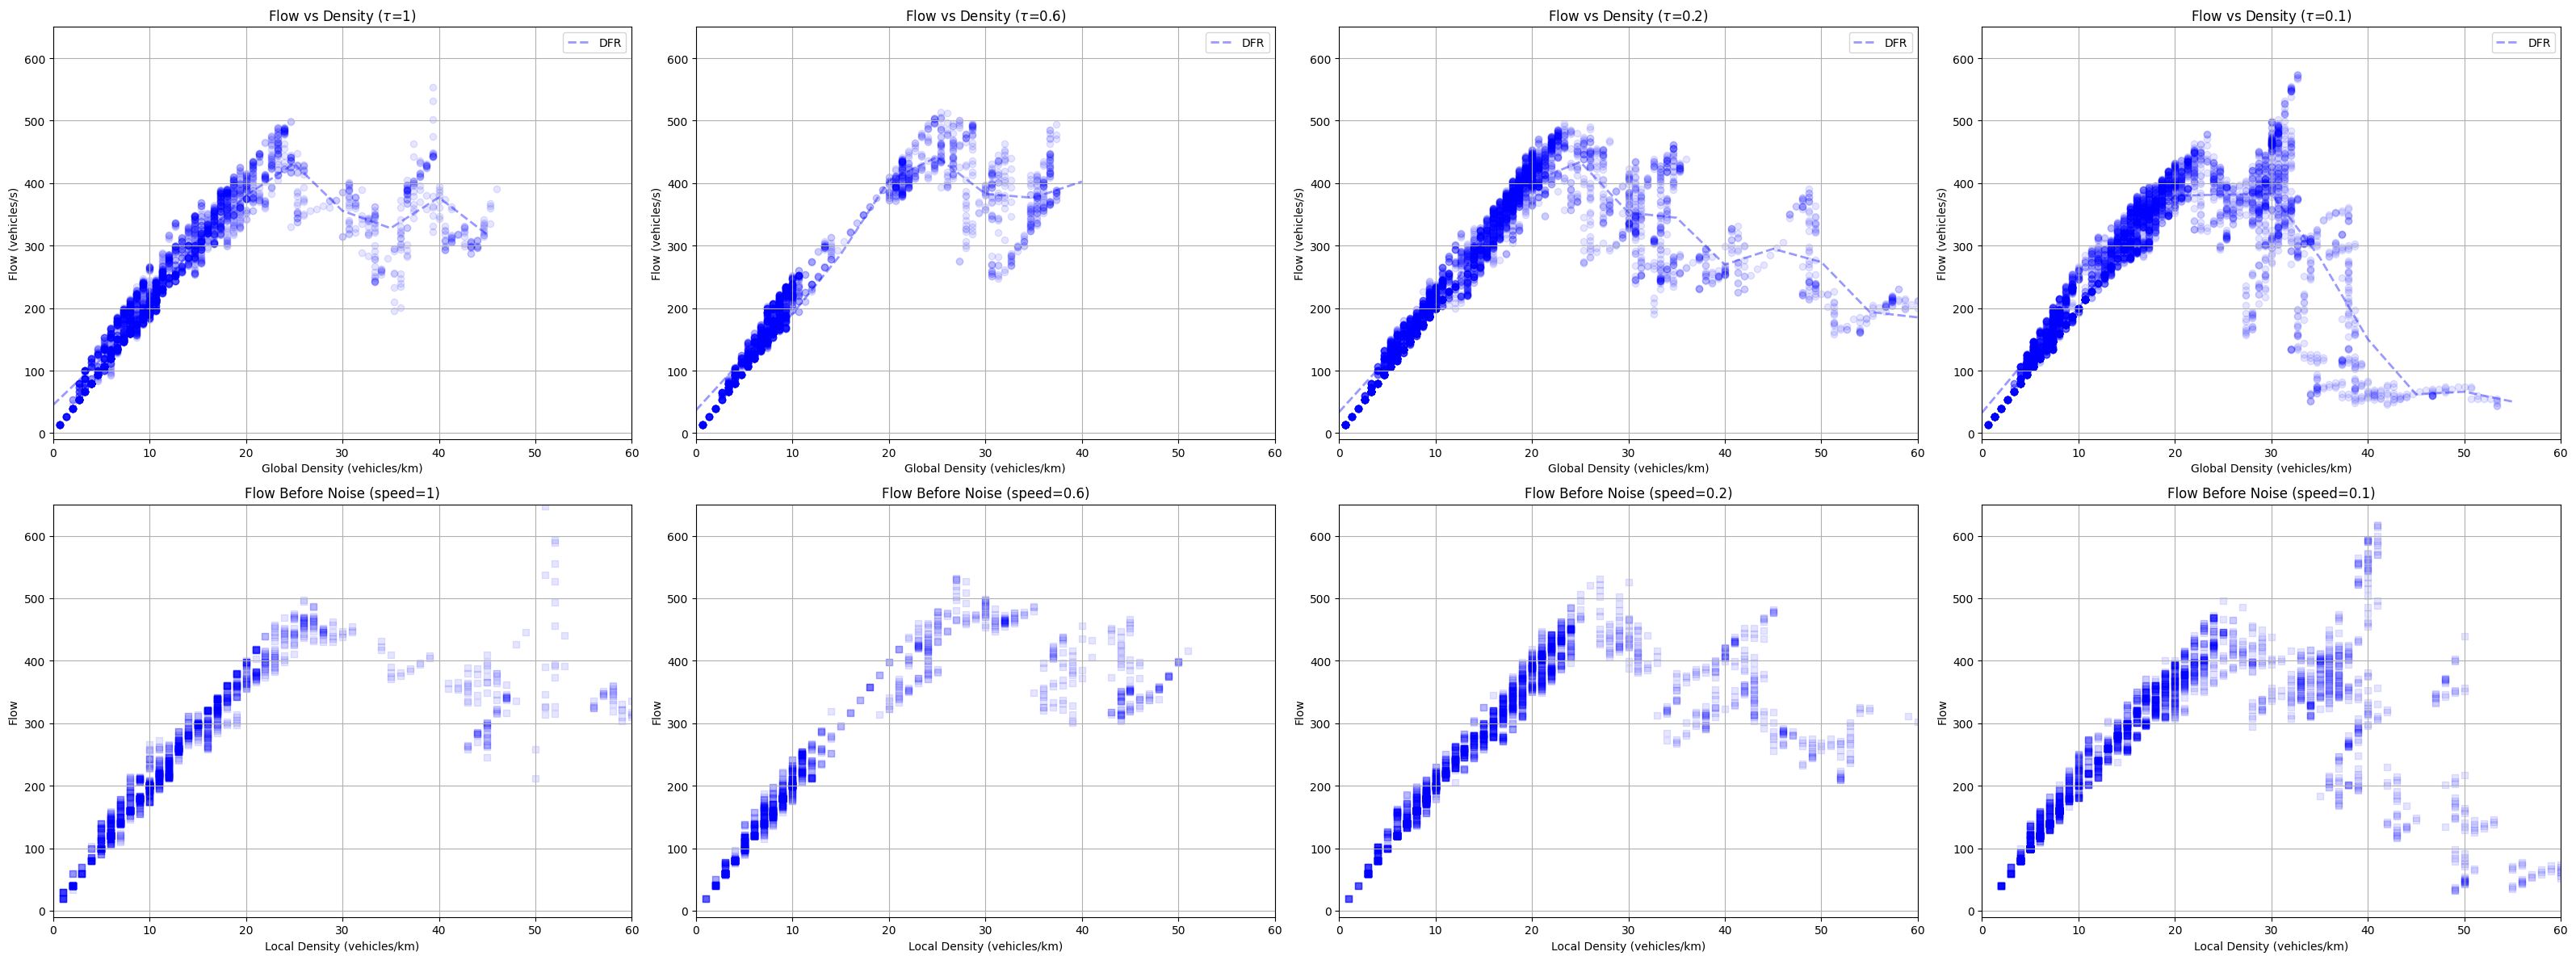

In [51]:
# v_mean_log_dfr = pd.read_csv("./20241213_115228/v_mean_log_dfr.csv")
# v_mean_log_vfr = pd.read_csv("./20241213_115228/v_mean_log_vfr.csv")
v_mean_log_dfr = pd.read_csv("./20241127_154955/v_mean_log_dfr.csv")
v_mean_log_vfr = pd.read_csv("./20241127_154955/v_mean_log_vfr.csv")

def draw_fd_before_and_after(density_increment, communication_speeds, xmax=200, ymax=1000, save_path="output.png", **kwargs):
    dfr_vmean = kwargs.get("dfr_vmean", [])
    vfr_vmean = kwargs.get("vfr_vmean", [])

    DFR_df = pd.DataFrame(dfr_vmean)
    VFR_df = pd.DataFrame(vfr_vmean)

    # プロットの準備
    num_cols = len(communication_speeds)  # 横の列数はcommunication_speedsの数
    fig, axes = plt.subplots(2, num_cols, figsize=(8 * num_cols, 12))

    # 各communication_speedごとにデータを処理
    for i, speed in enumerate(communication_speeds):
        # DFRデータをフィルタリング
        DFR_data = DFR_df[(DFR_df["time"] % 0.5 == 0) & 
                          (DFR_df["communication_speed"] == speed) & 
                         # (VFR_df["noise_forecast_time"] == 10) &
                          # (DFR_df["TTC"] == 1.6) &
                          (DFR_df["is_success"] == True)]
        DFR_data = (DFR_data.groupby("density", group_keys=False)
                .apply(lambda g: g[g["flow"].between(g["flow"].quantile(0.03), g["flow"].quantile(0.97))])
                .reset_index(drop=True))
        DFR_data = DFR_data[~((DFR_data["density"] >= 40) & (DFR_data["flow"] > 400))]
        
        dfr_bn = DFR_data[DFR_data["v_mean_before_noise"] > 0]  # df before noise
        dfr_an = DFR_data[DFR_data["v_mean_after_noise"] > 0]  # df after noise

        # VFRデータをフィルタリング
        VFR_data = VFR_df[(VFR_df["time"] % 0.5 == 0) & 
                          # (VFR_df["TTC"] == 4.0) &
                          # (VFR_df["noise_forecast_time"] == 10) &
                          (VFR_df["is_success"] == True)]
        VFR_data = (VFR_data.groupby("density", group_keys=False)
                .apply(lambda g: g[g["flow"].between(g["flow"].quantile(0.03), g["flow"].quantile(0.97))])
                .reset_index(drop=True))
        vfr_bn = VFR_data[VFR_data["v_mean_before_noise"] > 0]  # df before noise
        vfr_an = VFR_data[VFR_data["v_mean_after_noise"] > 0]  # df after noise

        # 1つ目のグラフ (Flow vs Density)
        ax1 = axes[0, i]
        ax1.scatter(DFR_data['density'], DFR_data['flow'], marker='o', color='b', alpha=0.1)
        # ax1.scatter(VFR_data['density'], VFR_data['flow'], marker='o', color='red', alpha=0.1)

        # 平均線を追加
        density_points = np.arange(0, 800, 5)
        mean_flow_dfr = [DFR_data[(DFR_data['density'] >= d - density_increment) & 
                                  (DFR_data['density'] < d + density_increment)]['flow'].mean() for d in density_points]
        # mean_flow_vfr = [VFR_data[(VFR_data['density'] >= d - density_increment) & 
        #                           (VFR_data['density'] < d + density_increment)]['flow'].mean() for d in density_points]
        ax1.plot(density_points, mean_flow_dfr, color='blue', linestyle='--', linewidth=2, label='DFR', alpha=0.4)
        # ax1.plot(density_points, mean_flow_vfr, color='red', linestyle='--', linewidth=2, label='VFR', alpha=0.4)

        ax1.legend()
        ax1.set_title(f'Flow vs Density ($\\tau$={speed})')
        ax1.set_xlabel('Global Density (vehicles/km)')
        ax1.set_ylabel('Flow (vehicles/s)')
        ax1.grid(True)
        ax1.set_xlim(0, xmax)
        ax1.set_ylim(-10, ymax)

        # 2つ目のグラフ (Flow Before Noise)
        ax2 = axes[1, i]
        ax2.scatter(dfr_bn['rho_before_noise'], dfr_bn['flow_before_noise'], marker='s', color='blue', alpha=0.1)
        # ax2.scatter(vfr_bn['rho_before_noise'], vfr_bn['flow_before_noise'], marker='s', color='red', alpha=0.1)

        # 平均線を追加
        mean_flow_bn_dfr = [dfr_bn[(dfr_bn['rho_before_noise'] >= d - density_increment) & 
                                   (dfr_bn['rho_before_noise'] < d + density_increment)]['flow_before_noise'].mean() for d in density_points]
        # mean_flow_bn_vfr = [vfr_bn[(vfr_bn['rho_before_noise'] >= d - density_increment) & 
        #                            (vfr_bn['rho_before_noise'] < d + density_increment)]['flow_before_noise'].mean() for d in density_points]
        # ax2.plot(density_points, mean_flow_bn_dfr, color='blue', linestyle='--', linewidth=2, label='DFR', alpha=0.4)
        # ax2.plot(density_points, mean_flow_bn_vfr, color='r', linestyle='--', linewidth=2, label='VFR', alpha=0.4)

        ax2.set_title(f'Flow Before Noise (speed={speed})')
        ax2.set_xlabel('Local Density (vehicles/km)')
        ax2.set_ylabel('Flow')
        ax2.grid(True)
        ax2.set_xlim(0, xmax)
        ax2.set_ylim(-10, ymax)

    # レイアウトの調整と表示
    plt.savefig(save_path)
    plt.tight_layout()
    plt.show()

# 使用例
communication_speeds = [1, 0.6, 0.2, 0.1]
draw_fd_before_and_after(3, communication_speeds, xmax=60, ymax=650, save_path="comparison_of_tau", dfr_vmean=v_mean_log_dfr, vfr_vmean=v_mean_log_vfr)
# pd.DataFrame(v_mean_log_dfr).head()

In [27]:
v_mean_log_dfr.head()

,is_success,noise_forecast_time,noise_period,communication_speed,TTC,lambda,NOISE_FREQUENCY,time,v_mean,density,...,flow,car_num_before_noise,car_num_after_noise,v_mean_before_noise,v_mean_after_noise,rho_before_noise,rho_after_noise,flow_before_noise,flow_after_noise,details
0,True,12,5,0.1,1.5,4.01,15,1.5,20.0,0.666667,...,13.333333,0,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,True,12,5,0.1,1.5,4.01,15,2.0,20.0,0.666667,...,13.333333,0,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,True,12,5,0.1,1.5,4.01,15,2.5,20.0,0.666667,...,13.333333,0,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,True,12,5,0.1,1.5,4.01,15,3.0,20.0,0.666667,...,13.333333,0,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,True,12,5,0.1,1.5,4.01,15,3.5,20.0,0.666667,...,13.333333,0,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


30


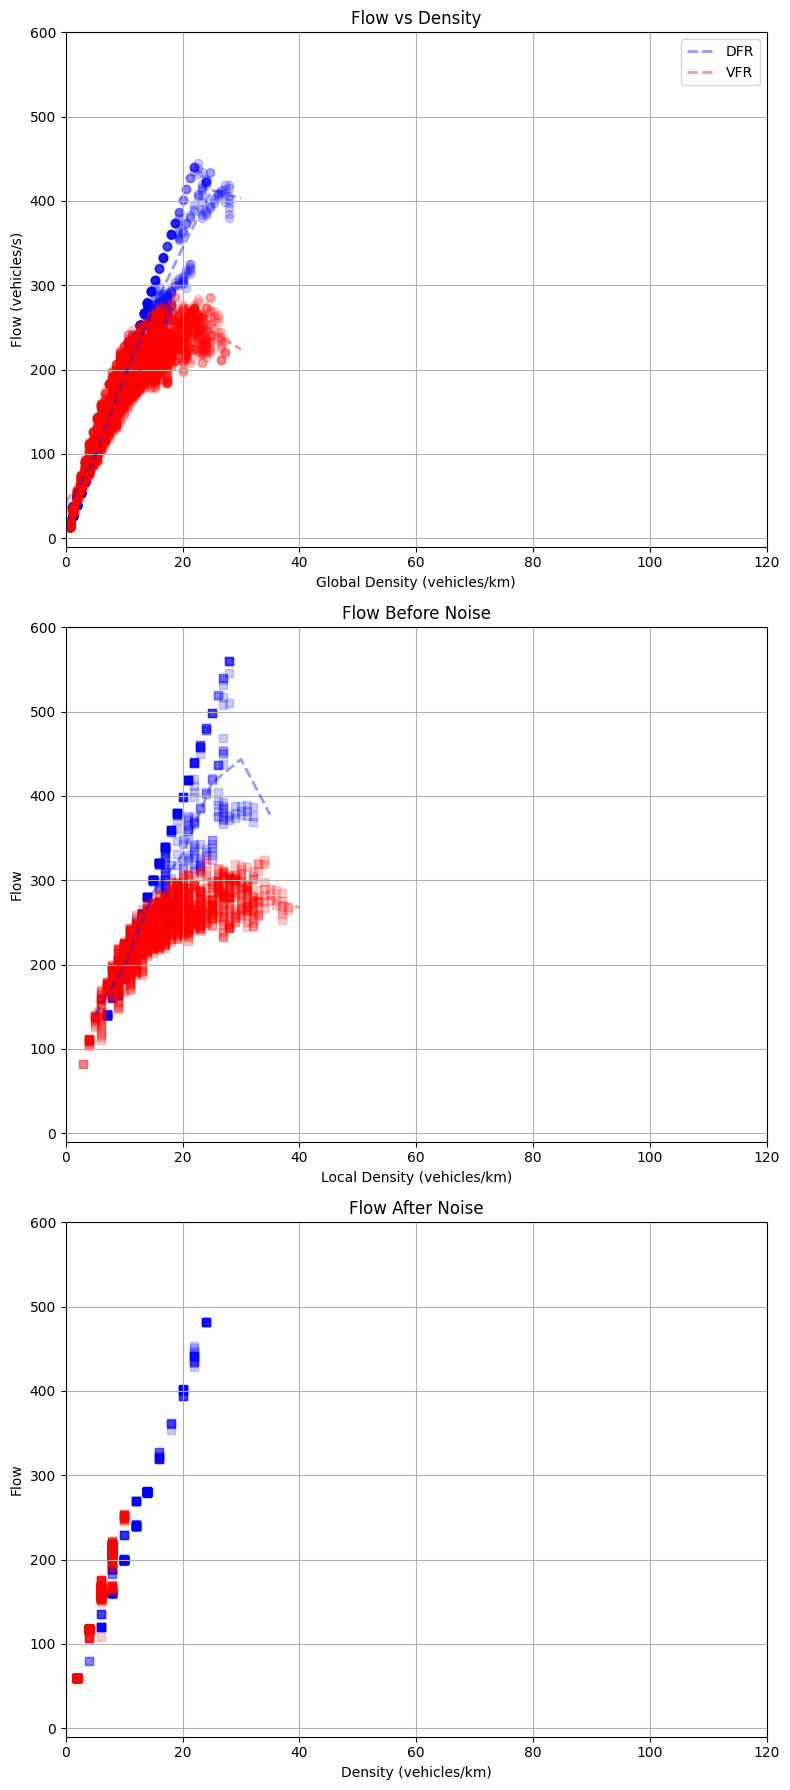

In [24]:
# DFR_data = DFR_df[(DFR_df["time"] % 0.5 == 0) & 
#                           (DFR_df["communication_speed"] == speed) & 
#                          # (VFR_df["noise_forecast_time"] == 10) &
#                           (DFR_df["TTC"] == 1.6) &
#                           (DFR_df["is_success"] == True)]

def draw_fd_before_and_after(density_increment, xmax=200, ymax=1000, **kwargs):
    dfr_vmean = kwargs.get("dfr_vmean", [])
    vfr_vmean = kwargs.get("vfr_vmean", [])
    noise_freq = kwargs.get("noise_freq",10)
    noise_period = kwargs.get("noise_period",5)
    print(noise_freq)

    DFR_df = pd.DataFrame(dfr_vmean)
    VFR_df = pd.DataFrame(vfr_vmean)

    # DFRのデータを整理
    # DFR_data = DFR_df[(DFR_df["time"]%0.5 == 0)]
    DFR_data = DFR_df[(DFR_df["time"]%0.5 == 0) & \
                        (DFR_df["communication_speed"]== 0.2) & \
                        (DFR_df["NOISE_FREQUENCY"]== noise_freq) & \
                        (DFR_df["noise_period"]== 10) & \
                        (DFR_df["is_success"]== True)]
    dfr_bn = DFR_data[DFR_data["v_mean_before_noise"] > 0] # df before noise
    dfr_an = DFR_data[DFR_data["v_mean_after_noise"] > 0] # df after noise

    # 同様にVFRのデータを整理
    # VFR_data = VFR_df[VFR_df["time"]%0.5 == 0]
    VFR_data = VFR_df[(VFR_df["NOISE_FREQUENCY"] == 30) & \
                        (VFR_df["NOISE_FREQUENCY"] == noise_freq) & \
                        (VFR_df["noise_period"]== noise_period) & \
                        (VFR_df["time"]%0.5 == 0) & \
                        (VFR_df["is_success"]== True)]
    vfr_bn = VFR_data[VFR_data["v_mean_before_noise"] > 0] # df before noise
    vfr_an = VFR_data[VFR_data["v_mean_after_noise"] > 0] # df after noise



    # ここから描画開始
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 18))
    
    # 1つ目のグラフ (flow_total vs density)
    # ax1.plot(data['local_density'], data['flow'], marker='s', linestyle='--', color='b')
    ax1.scatter(DFR_data['density'], DFR_data['flow'], marker='o', color='b', alpha=0.2)
    ax1.scatter(VFR_data['density'], VFR_data['flow'], marker='o', color='red', alpha=0.2)

    # 平均線を追加
    density_points = np.arange(0, 800, 5)
    mean_flow_dfr = [DFR_data[(DFR_data['density'] >= d - density_increment) & (DFR_data['density'] < d + density_increment)]['flow'].mean() for d in density_points]
    mean_flow_vfr = [VFR_data[(VFR_data['density'] >= d - density_increment) & (VFR_data['density'] < d + density_increment)]['flow'].mean() for d in density_points]
    ax1.plot(density_points, mean_flow_dfr, color='blue', linestyle='--', linewidth=2, label='DFR', alpha=0.4)
    ax1.plot(density_points, mean_flow_vfr, color='red', linestyle='--', linewidth=2, label='VFR', alpha=0.4)
    
    ax1.legend()
    ax1.set_title('Flow vs Local Density')
    ax1.set_xlabel('Global Density (vehicles/km)')
    ax1.set_ylabel('Flow (vehicles/s)')
    ax1.set_title('Flow vs Density')
    ax1.grid(True)
    ax1.set_xlim(0, xmax)  # x軸の範囲を設定
    ax1.set_ylim(-10, ymax) 
    
    # 2つ目のグラフ (ノイズ手前)
    ax2.scatter(dfr_bn['rho_before_noise'], dfr_bn['flow_before_noise'], marker='s', color='blue', alpha=0.2)
    ax2.scatter(vfr_bn['rho_before_noise'], vfr_bn['flow_before_noise'], marker='s', color='red', alpha=0.2)
    # 平均線を追加
    mean_flow_bn_dfr = [dfr_bn[(dfr_bn['rho_before_noise'] >= d - density_increment) & (dfr_bn['rho_before_noise'] < d + density_increment)]['flow_before_noise'].mean() for d in density_points]
    mean_flow_bn_vfr = [vfr_bn[(vfr_bn['rho_before_noise'] >= d - density_increment) & (vfr_bn['rho_before_noise'] < d + density_increment)]['flow_before_noise'].mean() for d in density_points]
    ax2.plot(density_points, mean_flow_bn_dfr, color='blue', linestyle='--', linewidth=2, label='DFR', alpha=0.4)
    ax2.plot(density_points, mean_flow_bn_vfr, color='r', linestyle='--', linewidth=2, label='VFR', alpha=0.4)
    
    ax2.set_xlabel('Local Density (vehicles/km)')
    ax2.set_ylabel('Flow')
    ax2.set_title('Flow Before Noise')  
    ax2.grid(True)
    ax2.set_xlim(0, xmax)  # x軸の範囲を設定
    ax2.set_ylim(-10, ymax) 
    

    # 3つ目のグラフ (ノイズ後)
    ax3.scatter(dfr_an['rho_after_noise'], dfr_an['flow_after_noise'], marker='s', color='blue', alpha=0.2)
    ax3.scatter(vfr_an['rho_after_noise'], vfr_an['flow_after_noise'], marker='s', color='red', alpha=0.2)
    ax3.set_xlabel('Density (vehicles/km)')
    ax3.set_ylabel('Flow')
    ax3.set_title('Flow After Noise')  
    ax3.grid(True)
    ax3.set_xlim(0, xmax)  # x軸の範囲を設定
    ax3.set_ylim(-10, ymax) 
    
    
    
    # レイアウトの調整と表示
    plt.tight_layout()
    plt.show()

draw_fd_before_and_after(3, xmax=120, ymax=600, noise_freq=30, noise_period=5, dfr_vmean=v_mean_log_dfr, vfr_vmean = v_mean_log_vfr)

### 以下はシミュレーションがFailした時のデバッグ用

In [10]:
#arrival_time = arrival_time_log[0]["arrival_times"]
#print(arrival_time)
arrival_time = [14.079873466431813, 16.079873466431813, 18.079873466431813, 23.372786981651853, 25.372786981651853, 27.372786981651853, 29.372786981651853, 31.372786981651853, 33.372786981651856, 35.372786981651856, 43.463117637846736, 47.221421804737, 49.448390317586636, 52.118697848191566, 57.33324793905273, 59.33324793905273, 63.648166446258706, 65.6481664462587, 67.6481664462587, 85.02790036351513, 89.45998856511873, 94.57587805000969, 96.69468347815501, 105.0939263022489, 111.68012922623183, 126.27658655147054, 128.27658655147053, 130.27658655147053, 140.73083336379236, 144.42530039397244, 146.42530039397244, 152.41275860392423, 155.7225097846343, 167.5477573455385, 169.5477573455385, 179.17264262069105, 181.38421436055992, 189.39711728430004, 191.80252701800958, 194.07117497500548, 196.07239159102937, 205.97673259448723, 207.97673259448723, 212.84999870634053, 214.84999870634053, 216.84999870634053, 220.7585702885048, 229.2597175613904, 231.2597175613904, 233.2597175613904, 235.32130504410276, 239.9040350464218, 252.8289019607949, 255.28609403251068, 257.6440426578612, 259.6440426578612, 264.62154497709514, 269.22651286526707, 271.22651286526707, 273.22651286526707, 275.22651286526707, 277.22651286526707, 281.49063409371536, 283.49063409371536, 285.49063409371536, 287.49063409371536, 291.3827716971806, 295.87207252879125, 312.85136679241134, 314.85136679241134, 316.85136679241134, 321.2884057042854, 324.4176805524133, 328.73818842504704, 332.0291378166873, 334.99640572242004, 340.0135031148197, 343.92326697306163, 347.9261586424505, 349.9261586424505, 351.9261586424505, 354.0430574583008, 366.13717612081564, 369.68048970844575, 371.68048970844575, 387.1431715057874, 393.11474359295056, 395.11474359295056, 403.48980462690054, 406.4607392540496, 408.4607392540496, 412.37375925374545, 414.37375925374545, 417.48378342209134, 420.44940499595657, 422.44940499595657, 424.44940499595657, 426.44940499595657, 429.53692426029625, 433.8272052226747, 437.7791351458296, 447.14727912021965, 458.38964046820473, 460.38964046820473, 462.9044521170923, 468.4167731000823, 470.4167731000823, 474.8029211864903, 476.8029211864903, 483.0668162311736, 491.6764379942443, 501.0572779517108, 503.0572779517108, 505.0572779517108, 507.0572779517108, 512.2473386688755, 514.2473386688755, 522.158877880834, 532.6494274256884, 537.5329943527857, 542.0458419988227, 544.0458419988227, 546.0458419988227, 548.0458419988227, 550.0458419988227, 552.2864749386696, 554.302440711668, 557.7568999728076, 561.187496537816, 564.885291210481, 566.885291210481, 568.885291210481, 576.5906660418362, 582.5988986654988, 591.6201465215337, 594.2048311768078, 600.2452769484295, 602.2452769484295, 604.2452769484295, 612.2716805114396, 616.2459521131086, 618.2459521131086, 625.1867569781472, 627.1867569781472, 636.0983604154924, 641.869041493558, 643.869041493558, 647.2625962103048, 649.2625962103048, 651.2625962103048, 654.1799303348494, 657.6222546554079, 660.0573762998187, 665.4158145804157, 669.0305322445672, 687.690356915182, 693.2778772436546, 696.61940987463, 698.643195928523, 700.643195928523, 702.643195928523, 704.643195928523, 706.643195928523, 718.2449124081292, 720.2449124081292, 724.7568091651726, 732.8934816201358, 740.1255117580858, 742.1255117580858, 744.3624277565418, 746.3624277565418, 749.378645895053, 751.8332307655289, 753.9235681089846, 755.9235681089846, 757.9282218625431, 760.8988806991694, 775.4922622037157, 777.6493549723956, 779.6493549723956, 781.6493549723956, 783.6493549723956, 793.2393802828046, 795.2393802828046, 799.590066542249, 803.2102038437907, 811.6391849298836, 814.2122510001129, 816.2122510001129, 818.2122510001129, 820.2122510001129, 822.2122510001129, 824.2122510001129, 826.9677046366477, 833.1317027739011, 836.1315142375839, 838.1315142375839, 840.1315142375839, 842.1315142375839, 844.2950230643534]

def register_initial_eta(cars, eta_table, waypoints):
    for idx, car in enumerate(cars):
        desired_eta_list = car.create_desired_eta(waypoints)
        is_valid = eta_table.validate(desired_eta_list)
        if is_valid:
            eta_table.register(desired_eta_list)
        else:
            calibration_info = {"desired_list": desired_eta_list}
            calibrated_list, _ = eta_table.calibrate_list(**calibration_info)
            # print(calibrated_list)
            # print()
            eta_table.register(calibrated_list)
            car.my_list = calibrated_list

CARS = [Cars(arrival_time=time, index=index, v_mean=MEAN_SPEED, v_max = MAX_SPEED, a_max=MAX_ACC, a_min=MAX_ACC)
              for index, time in enumerate(arrival_times)]

eta_table = ReservationTable(waypoints = WAYPOINTS, global_params = {"DESIRED_TTC":TTC})
register_initial_eta(CARS, eta_table, WAYPOINTS)

simulation = DFRSimulation(TOTAL_TIME = TOTAL_TIME, TIME_STEP = TIME_STEP, TOTAL_LENGTH = TOTAL_LENGTH, CARS = CARS, TTC=TTC, \
                          reservation_table = reservation_table, create_noise=create_noise, COMMUNICATION_SPEED=COMMUNICATION_SPEED, DENSITY=LAMBDA)
# simulation.conduct_simulation(should_plot=False, plot_start=10, plot_finish=90)
# cProfile.run('simulation.conduct_simulation(should_plot=False, plot_start=200, plot_finish=250 )', 'profile_result.prof')

vfr_simulation = VFRSimulation(TOTAL_TIME = 500, TIME_STEP = TIME_STEP, TOTAL_LENGTH = TOTAL_LENGTH, dfr_reference=simulation, car_params=car_params)
vfr_simulation.conduct_simulation(should_plot=False, plot_start=160, plot_finish=300)

Simulation Progress VFR:   0%|          | 0/8000 [00:00<?, ?it/s]

In [15]:
import pstats

# 保存されたプロファイルデータを読み込む
stats = pstats.Stats('profile_result.prof')

# ディレクトリ情報を削除して見やすくする
stats.strip_dirs()

# 累積時間でソート
stats.sort_stats('cumulative')

# 上位10件を表示
stats.print_stats(40)


Thu Nov 21 10:34:27 2024    profile_result.prof

         842081186 function calls (818131722 primitive calls) in 365.883 seconds

   Ordered by: cumulative time
   List reduced from 1157 to 40 due to restriction <40>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     5659    0.145    0.000  367.839    0.065 base_events.py:1874(_run_once)
      2/1    0.000    0.000  365.882  365.882 {built-in method builtins.exec}
     5659    1.577    0.000  288.497    0.051 selectors.py:451(select)
   245355    4.759    0.000  208.040    0.001 eta_validator.py:4(validate_with_ttc)
     4805    0.965    0.000  204.420    0.043 DFRSimulation.py:219(find_first_ETA_influenced_car)
   216315    2.797    0.000  147.644    0.001 ReservationTable.py:74(update_with_request)
  1938044    3.906    0.000   97.758    0.000 frame.py:3856(__getitem__)
   492683    1.285    0.000   64.289    0.000 frame.py:3924(_getitem_bool_array)
   465082    0.867    0.000   56.294    0.000 generic.py:

### 続いて同じ条件でVFRを試す

arrival_timeやTTC、ノイズの発生タイミングはそのまま引き継ぐ. 


In [20]:
vfr_simulation = VFRSimulation(TOTAL_TIME = 500, TIME_STEP = TIME_STEP, TOTAL_LENGTH = TOTAL_LENGTH, dfr_reference=simulation, car_params=car_params)
vfr_simulation.conduct_simulation(should_plot=False)

Simulation Progress VFR:   0%|          | 0/8000 [00:00<?, ?it/s]

ID: 18, xcor=992.845671046997, v_x=27.50095242979219


ValueError: 狙った場所に止まることができません！

[{'time': 1.5, 'headway': 1500, 'v_x': 20.0, 'car_idx': 0, 'xcoor': 2.0}, {'time': 1.6, 'headway': 1500, 'v_x': 20.0, 'car_idx': 0, 'xcoor': 4.0}, {'time': 1.7000000000000002, 'headway': 1500, 'v_x': 20.0, 'car_idx': 0, 'xcoor': 6.0}, {'time': 1.8, 'headway': 1500, 'v_x': 20.0, 'car_idx': 0, 'xcoor': 8.0}, {'time': 1.9000000000000001, 'headway': 1500, 'v_x': 20.0, 'car_idx': 0, 'xcoor': 10.0}, {'time': 2.0, 'headway': 1500, 'v_x': 20.0, 'car_idx': 0, 'xcoor': 12.0}, {'time': 2.1, 'headway': 1500, 'v_x': 20.0, 'car_idx': 0, 'xcoor': 14.0}, {'time': 2.2, 'headway': 1500, 'v_x': 20.0, 'car_idx': 0, 'xcoor': 16.0}, {'time': 2.3000000000000003, 'headway': 1500, 'v_x': 20.0, 'car_idx': 0, 'xcoor': 18.0}, {'time': 2.4000000000000004, 'headway': 1500, 'v_x': 20.0, 'car_idx': 0, 'xcoor': 20.0}]
     local_density     v_mean          flow
0              1.0  26.943253  2.694325e+01
1              2.0   2.528332  5.056664e+00
2              3.0  13.984087  4.195226e+01
3              4.0  13.8597

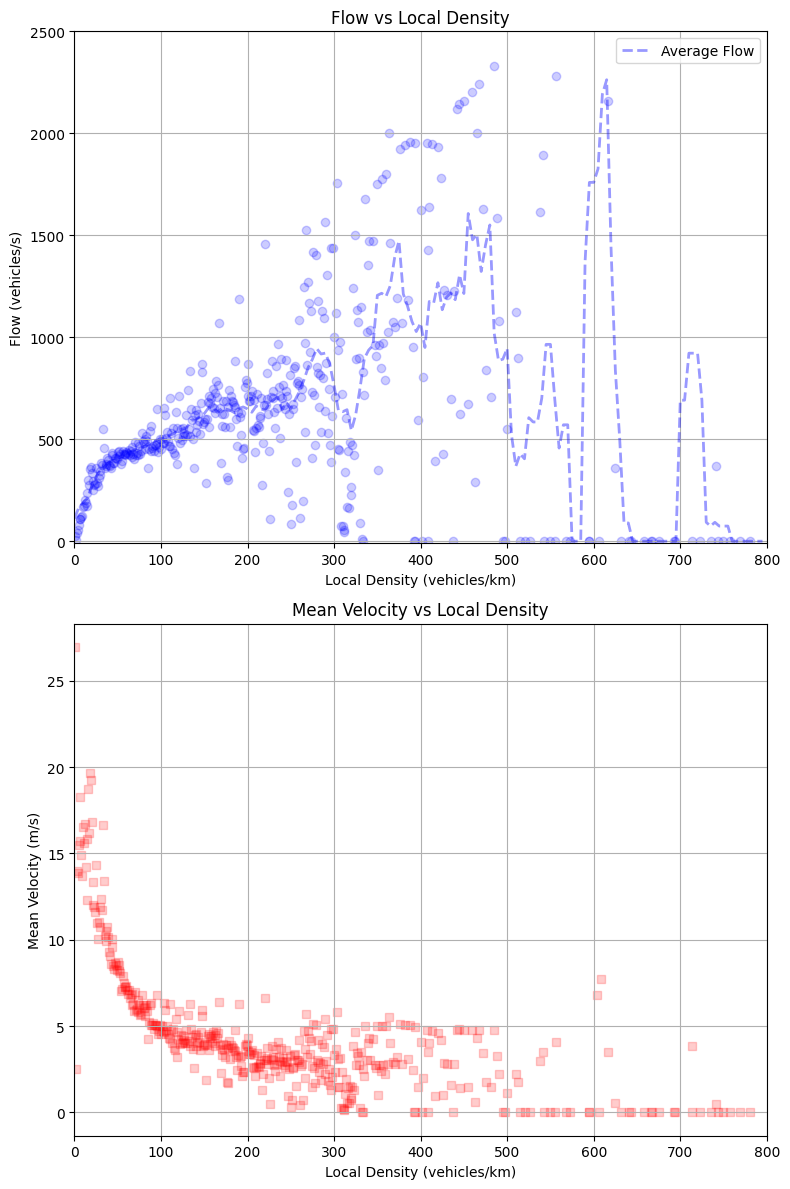

In [8]:
def process_headway_data(df):
    # 1. headwayの逆数 * 1000 (=1kmあたりの密度)をlocal_densityとしてデータフレームのカラムに追加
    df['local_density'] = 1000 / df['headway']

    # 2. local_densityごとに平均をとる
    # まずはlocal_densityを整数に丸めて、L-0.5 < local_density < L+0.5 の範囲にあるものを同じグループとする
    df['density_group'] = df['local_density'].round(0)

    # density_groupごとにv_xの平均を計算
    df_grouped = df.groupby('density_group')['v_x'].mean().reset_index()

    # カラム名を適切に変更
    df_grouped.rename(columns={'v_x': 'v_mean', 'density_group': 'local_density'}, inplace=True)

    # 3. local_densityとv_meanをかけたflowという値をdf_newに新たなカラムとして追加
    df_grouped['flow'] = df_grouped['local_density'] * df_grouped['v_mean']

    # 結果を返す
    return df_grouped

def show_fd(simulation):
    headway_list = simulation.headway_log
    print(simulation)
    print(headway_list[:10])
    headway_df = pd.DataFrame(headway_list)
    data = process_headway_data(headway_df)
    print(data)
    data_filtered = data[(data["local_density"] >=  300) & (data["v_mean"] > 5)]
    data_length = len(data_filtered)
    print(f"この条件での行数: {data_length}行")
    # 2つのグラフを縦に並べて描画
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))
    
    # 1つ目のグラフ (flow vs local_density)
    # ax1.plot(data['local_density'], data['flow'], marker='s', linestyle='--', color='b')
    ax1.scatter(data['local_density'], data['flow'], marker='o', color='b', alpha=0.2)

    # 平均線を追加
    density_points = np.arange(0, 800, 5)
    mean_flow = [data[(data['local_density'] >= d - 15) & (data['local_density'] < d + 15)]['flow'].mean()
                 for d in density_points]
    ax1.plot(density_points, mean_flow, color='blue', linestyle='--', linewidth=2, label='Average Flow', alpha=0.4)
    
    ax1.legend()
    ax1.set_title('Flow vs Local Density')
    ax1.set_xlabel('Local Density (vehicles/km)')
    ax1.set_ylabel('Flow (vehicles/s)')
    ax1.grid(True)
    ax1.set_xlim(0, 800)  # x軸の範囲を設定
    ax1.set_ylim(-10, 2500)  # x軸の範囲を設定
    
    # 2つ目のグラフ (v_mean vs local_density)
    # ax2.plot(data['local_density'], data['v_mean'], linestyle='--', color='r')
    ax2.scatter(data['local_density'], data['v_mean'], marker='s', color='r', alpha=0.2)
    ax2.set_title('Mean Velocity vs Local Density')
    ax2.set_xlabel('Local Density (vehicles/km)')
    ax2.set_ylabel('Mean Velocity (m/s)')
    ax2.grid(True)
    ax2.set_xlim(0, 800)  # x軸の範囲を設定
    
    
    # レイアウトの調整と表示
    plt.tight_layout()
    plt.show()

show_fd(simulation)

In [17]:
# ここからはまとめてシミュレーションするためのコード

DENSITY_LIST = [10, 4, 3, 2.4, 1.8]
NOISE_FORECAST_TIME_LIST = [5]
NOISE_PERIOD_LIST = [5]
COMMU_SPEED_LIST = [0.2]
TOTAL_TIME=200
results = []
arrival_time_log = []
import sys
import io
from collections import defaultdict

def process_headway_data(df):
    # 1. headwayの逆数 * 1000 (=1kmあたりの密度)をlocal_densityとしてデータフレームのカラムに追加
    df['local_density'] = 1000 / df['headway']

    # 2. local_densityごとに平均をとる
    # まずはlocal_densityを整数に丸めて、L-0.5 < local_density < L+0.5 の範囲にあるものを同じグループとする
    df['density_group'] = df['local_density'].round(0)

    # density_groupごとにv_xの平均を計算
    df_grouped = df.groupby('density_group')['v_x'].mean().reset_index()

    # カラム名を適切に変更
    df_grouped.rename(columns={'v_x': 'v_mean', 'density_group': 'local_density'}, inplace=True)

    # 3. local_densityとv_meanをかけたflowという値をdf_newに新たなカラムとして追加
    df_grouped['flow'] = df_grouped['local_density'] * df_grouped['v_mean']

    # 結果を返す
    return df_grouped

all_headway_dfs = []    
total_iterations = len(NOISE_FORECAST_TIME_LIST) * len(NOISE_PERIOD_LIST) * len(COMMU_SPEED_LIST) * len(DENSITY_LIST)
with tqdm(total=total_iterations) as pbar:
    for noise_forecast_time in NOISE_FORECAST_TIME_LIST:
        for noise_period in NOISE_PERIOD_LIST:
            for communication_speed in COMMU_SPEED_LIST:
                for idx, density in enumerate(DENSITY_LIST):
                    print(f"Running simulation with density={density}, noise_forecast_time={noise_forecast_time}, noise_period={noise_period}, communication_speed={communication_speed}")
                
                    arrival_times = generate_arrival_times(CAR_NUM, density, TOTAL_TIME)
                    arrival_times.append(TOTAL_TIME + TTC +0.2)
                    CARS = [Cars(arrival_time=time, index=index, v_mean=MEAN_SPEED, v_max = MAX_SPEED, a_max=MAX_ACC, a_min=MAX_ACC)
                              for index, time in enumerate(arrival_times)]
                    arrival_time_log.append({"density": density, "arrival_times":arrival_times})

                    def create_noise(current_time):
                        if current_time % NOISE_FREQUENCY == 0 and current_time > 0:
                            # ノイズを未来に発生させる（この瞬間、だと偶然ハマる車が出てきしまう）
                            return {"x": [520, 550], "t": [current_time + noise_forecast_time, current_time + noise_forecast_time + noise_period]}
                        # この場合はノイズを発生させない.
                        return None
                
                    # まずはDFR
                    # 標準出力を無効化
                    original_stdout = sys.stdout
                    sys.stdout = io.StringIO()
                    reservation_table = ReservationTable(waypoints = WAYPOINTS, global_params = {"DESIRED_TTC":TTC})
                    register_initial_eta(CARS)
                
                    dfr_simulation = DFRSimulation(TOTAL_TIME = TOTAL_TIME, TIME_STEP = TIME_STEP, TOTAL_LENGTH = TOTAL_LENGTH, CARS = CARS, \
                                          reservation_table = reservation_table, DENSITY=density, COMMUNICATION_SPEED=communication_speed, create_noise=create_noise)
                    try:
                        dfr_simulation.conduct_simulation(should_plot=False)
                        headway_list = dfr_simulation.headway_log
                        headway_df = pd.DataFrame(headway_list)
                        headway_df = process_headway_data(headway_df)
                        # 追加カラムを追加する
                        headway_df['density'] = density
                        headway_df['noise_forecast_time'] = noise_forecast_time
                        headway_df['noise_period'] = noise_period
                        headway_df['communication_speed'] = communication_speed
                
                        # 結果をリストに追加
                        all_headway_dfs.append(headway_df)
                        
                
                    except:
                        sys.stdout = original_stdout
                        print(arrival_times)
                        
                    finally:
                        # 標準出力を元に戻す
                        sys.stdout = original_stdout
                    pbar.update(1)
                    
final_headway_df = pd.concat(all_headway_dfs, ignore_index=True)
               

  0%|          | 0/5 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/2000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress DFR, density=4:   0%|          | 0/2000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress DFR, density=3:   0%|          | 0/2000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress DFR, density=2.4:   0%|          | 0/2000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress DFR, density=1.8:   0%|          | 0/2000 [00:00<?, ?it/s]

[0.9958288129982859, 5.287233129036741, 8.59464779137927, 12.41331846102123, 15.35178948508543, 18.089027551552434, 21.686473194033372, 25.529885585952535, 28.738588920141332, 31.378984378605875, 34.15069324094699, 38.65461736127613, 42.198918455182785, 44.82187773076833, 47.74355633196187, 51.248831946417724, 55.803139174787816, 59.229418797468156, 62.999513051941044, 66.78782028356221, 71.02697798225786, 74.26037069872682, 78.09280366333712, 81.04959819369992, 83.92590031213548, 87.6810002060757, 91.15995049508086, 95.57577501493115, 99.71979174670052, 103.61323987259884, 107.34415195924623, 110.17723676263368, 114.31655631511981, 118.61473746052114, 122.22498233706457, 126.35813425375207, 130.16457913202967, 134.61603085666923, 138.30915595700654, 141.34660409333318, 144.99197966479127, 148.8968522850624, 152.6395259702966, 156.64599365656315, 160.03272764553176, 163.6837266270248, 166.38981340089035, 169.01848494283718, 171.76510882618564, 175.46834644834394, 178.61525117429943, 18

138


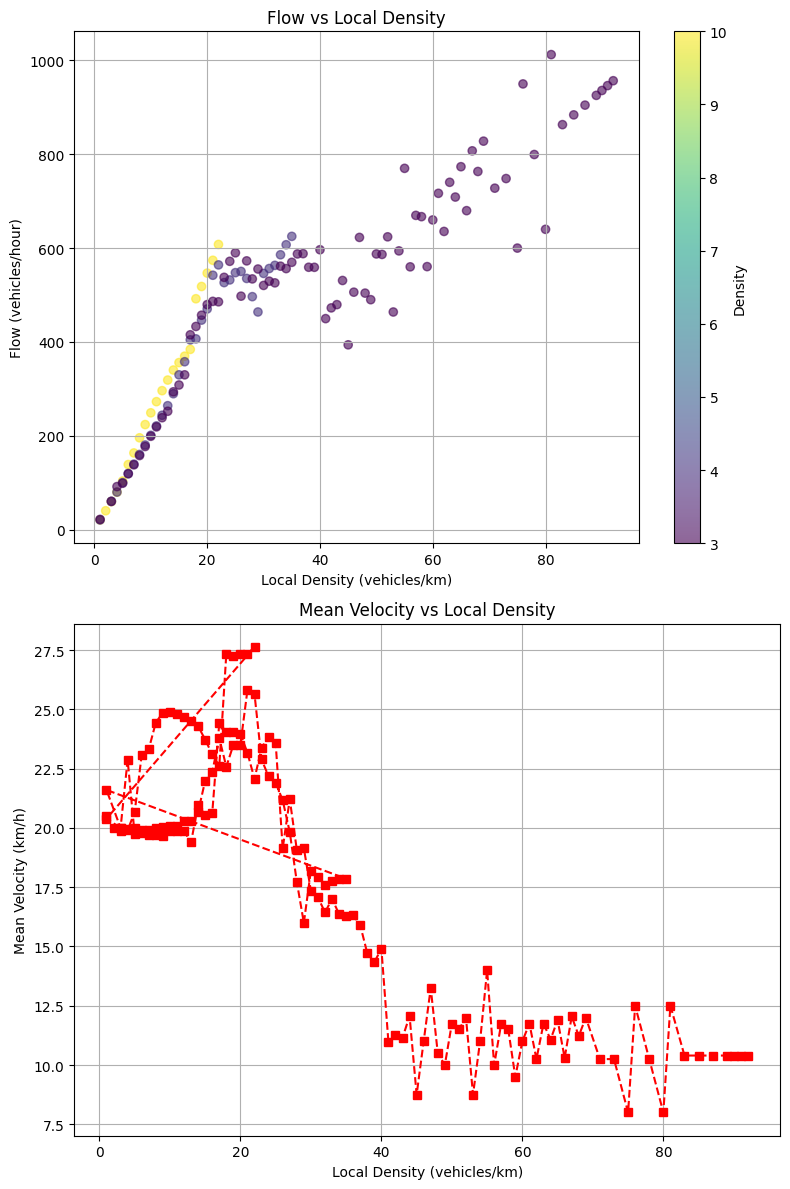

In [23]:
# 全てのheadway_dfを結合
final_headway_df = pd.concat(all_headway_dfs, ignore_index=True)
# final_headway_dfを出力
print(len(final_headway_df))
final_headway_df.to_csv("density.csv")

def plot_fd(df):
    # local_densityが0以上のデータを抽出
    data = df[df['local_density'] >= 0]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))
    
    # 1つ目のグラフ (flow vs local_density)
    scatter = ax1.scatter(data['local_density'], data['flow'], c=data['density'], cmap='viridis', marker='o', alpha=0.6)
    ax1.set_title('Flow vs Local Density')
    ax1.set_xlabel('Local Density (vehicles/km)')
    ax1.set_ylabel('Flow (vehicles/hour)')
    ax1.grid(True)
    
    # カラーバー（densityに基づいて色を変える）
    cbar = fig.colorbar(scatter, ax=ax1)
    cbar.set_label('Density')

    
    # 2つ目のグラフ (v_mean vs local_density)
    ax2.plot(data['local_density'], data['v_mean'], marker='s', linestyle='--', color='r')
    ax2.set_title('Mean Velocity vs Local Density')
    ax2.set_xlabel('Local Density (vehicles/km)')
    ax2.set_ylabel('Mean Velocity (km/h)')
    ax2.grid(True)
    
    # レイアウトの調整と表示
    plt.tight_layout()
    plt.show()

plot_fd(final_headway_df)

In [5]:
vfr_simulation = VFRSimulation(TOTAL_TIME = 500, TIME_STEP = TIME_STEP, TOTAL_LENGTH = TOTAL_LENGTH, dfr_reference=simulation, car_params=car_params)
vfr_simulation.conduct_simulation(should_plot=False)

Simulation Progress VFR:   0%|          | 0/4283 [00:00<?, ?it/s]

In [6]:
cars = vfr_simulation.CARS
car_front = cars[1]
car_back = cars[2]
print(car_front.xcorList[-10:-1])
print(car_front.is_crossing)
def create_v_list(car):
    vList = []
    for i, xcor in enumerate(car.xcorList):
        if i >= len(car.xcorList)-1:
            continue
        v = car.xcorList[int(i+1)] - xcor
        vList.append(v / TIME_STEP)
    return vList

vList = create_v_list(car_front)
print(vList[-10:-1])
v_mean_log = vfr_simulation.v_mean_log
max_flow_sum = max(item['flow_sum'] for item in v_mean_log)
print(max_flow_sum)

[1473.1321153718538, 1476.1321153718538, 1479.1321153718538, 1482.1321153718538, 1485.1321153718538, 1488.1321153718538, 1491.1321153718538, 1494.1321153718538, 1497.1321153718538]
False
[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0]
482.26039467201366


   lambda    flow type  calc_time[s]  ID_simulation
0    10.0  200.00  dfr           NaN            NaN
1     5.0  376.17  dfr           NaN            NaN
2     1.5  622.00  dfr           NaN            NaN
3     3.0  461.00  dfr           NaN            NaN
4     4.0  515.00  dfr           NaN            NaN


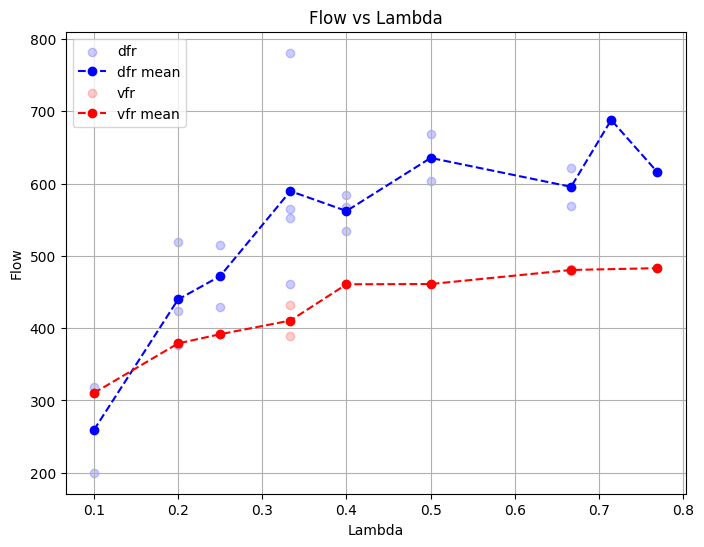

In [7]:
def plot_flow_vs_lambda_inverse(file_path):
    # CSVファイルを読み込む
    df = pd.read_csv(file_path)
    print(df.head())

    # lambdaの逆数を計算
    df['lambda_inverse'] = 1 / df['lambda']

    # vfr と dfr で異なる色を使ってプロット
    plt.figure(figsize=(8, 6))

    # dfrタイプのプロット
    dfr_data = df[df['type'] == 'dfr']
    dfr_grouped = dfr_data.groupby('lambda_inverse').agg({'flow': 'mean'}).reset_index()
    plt.scatter(dfr_data['lambda_inverse'], dfr_data['flow'], color='blue', label='dfr', alpha=0.2)
    plt.plot(dfr_grouped['lambda_inverse'], dfr_grouped['flow'], color='blue', marker='o', linestyle='--', label='dfr mean')

    # vfrタイプのプロット
    vfr_data = df[df['type'] == 'vfr']
    vfr_grouped = vfr_data.groupby('lambda_inverse').agg({'flow': 'mean'}).reset_index()
    plt.scatter(vfr_data['lambda_inverse'], vfr_data['flow'], color='red', label='vfr', alpha=0.2)
    plt.plot(vfr_grouped['lambda_inverse'], vfr_grouped['flow'], color='red', marker='o', linestyle='--', label='vfr mean')

    # グラフの装飾
    plt.xlabel('Lambda')
    plt.ylabel('Flow')
    plt.title('Flow vs Lambda')
    plt.legend()
    plt.grid(True)

plot_flow_vs_lambda_inverse("./result.csv")

In [8]:
def show_fd(dfr_simulation, vfr_simulation):
    # dfr_simulationの処理
    dfr_headway_list = dfr_simulation.headway_log
    dfr_headway_df = pd.DataFrame(dfr_headway_list)
    dfr_data = process_headway_data(dfr_headway_df)

    # vfr_simulationの処理
    vfr_headway_list = vfr_simulation.headway_log
    vfr_headway_df = pd.DataFrame(vfr_headway_list)
    vfr_data = process_headway_data(vfr_headway_df)

    # 2つのグラフを縦に並べて描画
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))
    
    # 1つ目のグラフ (flow vs local_density)
    # dfr_simulationのデータを青色でプロット
    ax1.scatter(dfr_data['local_density'], dfr_data['flow'], marker='o', color='b', alpha=0.2, label='DFR')
    # vfr_simulationのデータを赤色でプロット
    ax1.scatter(vfr_data['local_density'], vfr_data['flow'], marker='o', color='r', alpha=0.2, label='VFR')
    ax1.set_title('Flow vs Local Density')
    ax1.set_xlabel('Local Density (vehicles/km)')
    ax1.set_ylabel('Flow (vehicles/s)')
    ax1.grid(True)
    ax1.set_xlim(0, 400)  # x軸の範囲を設定
    ax1.set_ylim(-10, 2500)  # y軸の範囲を設定
    ax1.legend()

    # 2つ目のグラフ (v_mean vs local_density)
    # dfr_simulationのデータを青色でプロット
    ax2.scatter(dfr_data['local_density'], dfr_data['v_mean'], marker='s', color='b', alpha=0.2, label='DFR')
    # vfr_simulationのデータを赤色でプロット
    ax2.scatter(vfr_data['local_density'], vfr_data['v_mean'], marker='s', color='r', alpha=0.2, label='VFR')
    ax2.set_title('Mean Velocity vs Local Density')
    ax2.set_xlabel('Local Density (vehicles/km)')
    ax2.set_ylabel('Mean Velocity (m/s)')
    ax2.grid(True)
    ax2.set_xlim(0, 400)  # x軸の範囲を設定
    ax2.legend()
    
    # レイアウトの調整と表示
    plt.tight_layout()
    plt.show()

dfr_simulation= simulation
show_fd(dfr_simulation, vfr_simulation)

KeyError: 'headway'

In [4]:
def plot_v_mean_log(path, v_mean_dfr, v_mean_vfr):
    v_mean_log = v_mean_dfr
    # event_flgが"noise"のデータポイントを抽出する
    noise_time = [entry["time"]
                  for entry in v_mean_log if entry.get("event_flg") == "noise"]
    noise_v_mean = [entry["v_mean"]
                    for entry in v_mean_log if entry.get("event_flg") == "noise"]
    noise_times = [entry["time"]
                   for entry in v_mean_vfr if entry.get("event_flg") == "noise"]

    # timeとv_meanをそれぞれリストに抽出する
    time = [entry["time"] for entry in v_mean_log]
    v_mean = [entry["v_mean"] for entry in v_mean_log]
    v_mean_vfr = [entry["v_mean"] for entry in v_mean_vfr]

    # グラフを描画する
    plt.figure(figsize=(10, 8))
    plt.plot(time, v_mean, label="DFR",)
    plt.plot(time, v_mean_vfr, label="VFR")

    # ノイズのデータポイントを赤丸でプロットする
    # plt.scatter(noise_time, noise_v_mean, color='red', label='Noise Event', zorder=5)

    # ノイズ発生タイミングに赤線
    for n in noise_times:
        plt.axvline(x=n, color='orange', linestyle='--', alpha=0.5,
                    linewidth=1)

    # グラフのタイトルとラベルを設定する
    plt.title('Mean Velocity Over Time')
    plt.xlabel('Time')
    plt.ylabel('Mean Velocity')

    plt.xlim(0, 85)
    plt.ylim(0, 32)
    plt.legend()

    # グリッドを表示する
    plt.grid(True)
    plt.savefig(path)

plot_v_mean_log("./images/dfr/v_mean_log_dfr_vs_vfr.png", simulation.v_mean_log, vfr_simulation.v_mean_log)

NameError: name 'simulation' is not defined

In [6]:
# Fundamental Diagram作るように一気にやるためのコードを書く. 
DENSITY_LIST = [20, 16, 12, 10, 8, 6, 4, 3 , 2.8, 2.4, 2, 1.8, 1.6, 1.5]
#DENSITY_LIST = [20,2]
NOISE_FORECAST_TIME_LIST = [5,10,15, 20]
#NOISE_FORECAST_TIME_LIST=[5]
NOISE_PERIOD_LIST = [5]
COMMU_SPEED_LIST = [0.2, 0.5, 1, 1.5, 2]
# COMMU_SPEED_LIST=[0.2, 2]
results = []
arrival_time_log = []
import sys
import io
from collections import defaultdict


def collect_v_mean_by_density(data):
    cut_index = int(len(data) * 0.2)
    data = data[cut_index:]
    density_groups = defaultdict(list)
    for entry in data:
        density_groups[entry['density']].append(entry['v_mean'])
    
    # 各densityのv_meanの平均を計算
    density_mean_v_mean = {density: sum(v_means)/len(v_means) for density, v_means in density_groups.items()}
    return density_mean_v_mean
    
total_iterations = len(NOISE_FORECAST_TIME_LIST) * len(NOISE_PERIOD_LIST) * len(COMMU_SPEED_LIST) * len(DENSITY_LIST)

with tqdm(total=total_iterations) as pbar:
    for noise_forecast_time in NOISE_FORECAST_TIME_LIST:
        for noise_period in NOISE_PERIOD_LIST:
            for communication_speed in COMMU_SPEED_LIST:
                for idx, density in enumerate(DENSITY_LIST):
                    print(f"Running simulation with density={density}, noise_forecast_time={noise_forecast_time}, noise_period={noise_period}, communication_speed={communication_speed}")
                
                    arrival_times = generate_arrival_times(CAR_NUM, density, TOTAL_TIME)
                    arrival_times.append(TOTAL_TIME + TTC +0.2)
                    CARS = [Cars(arrival_time=time, index=index, v_mean=MEAN_SPEED, v_max = MAX_SPEED, a_max=MAX_ACC, a_min=MAX_ACC)
                              for index, time in enumerate(arrival_times)]
                    arrival_time_log.append({"density": density, "arrival_times":arrival_times})

                    def create_noise(current_time):
                        if current_time % NOISE_FREQUENCY == 0 and current_time > 0:
                            # ノイズを未来に発生させる（この瞬間、だと偶然ハマる車が出てきしまう）
                            return {"x": [420, 450], "t": [current_time + noise_forecast_time, current_time + noise_forecast_time + noise_period]}
                        # この場合はノイズを発生させない.
                        return None
                
                    # まずはDFR
                    reservation_table = ReservationTable(waypoints = WAYPOINTS, global_params = {"DESIRED_TTC":TTC})
                    register_initial_eta(CARS)
                    # 標準出力を無効化
                    original_stdout = sys.stdout
                    sys.stdout = io.StringIO()
                
                    dfr_simulation = DFRSimulation(TOTAL_TIME = TOTAL_TIME, TIME_STEP = TIME_STEP, TOTAL_LENGTH = TOTAL_LENGTH, CARS = CARS, \
                                          reservation_table = reservation_table, DENSITY=density, COMMUNICATION_SPEED=communication_speed, create_noise=create_noise)
                    result = {
                        "type": "dfr",
                        "density": density,
                        "v_mean": None,
                        "noise_forecast_time": noise_forecast_time,
                        "noise_period": noise_period,
                        "communication_speed": communication_speed,
                        "is_success": True
                    }

                    try:
                        dfr_simulation.conduct_simulation(should_plot=False)
                        dfr_log = dfr_simulation.v_mean_log
                        v_mean_by_density = collect_v_mean_by_density(dfr_log)
                        result["v_mean"] = v_mean_by_density
                
                    except:
                        result["is_success"] = False  # エラー発生時にis_successをFalseに設定
    
                    results.append(result)
                    sys.stdout = original_stdout
                
                
                    # 続いてVFR
                    result = {
                        "type": "vfr",
                        "density": density,
                        "v_mean": None,
                        "noise_forecast_time": noise_forecast_time,
                        "noise_period": noise_period,
                        "communication_speed": communication_speed,
                        "is_success": True
                    }
                    try:
                        original_stdout = sys.stdout
                        sys.stdout = io.StringIO()
                        vfr_simulation = VFRSimulation(TOTAL_TIME = TOTAL_TIME, TIME_STEP = TIME_STEP, TOTAL_LENGTH = TOTAL_LENGTH, dfr_reference=dfr_simulation, car_params=car_params)
                        vfr_simulation.conduct_simulation(should_plot=False)
                        vfr_log = vfr_simulation.v_mean_log
                        v_mean_by_density = collect_v_mean_by_density(vfr_log)
                        result["v_mean"] = v_mean_by_density
                        
                    except: 
                        # sys.stderr.write(f"VFR simulation error for density {density}: {e}\n")
                        result["is_success"] = False  # エラー発生時にis_successをFalseに設定
                        pass
                    finally:
                        # 標準出力を元に戻す
                        sys.stdout = original_stdout
                    results.append(result)
                    pbar.update(1)
print("DONE!")
result_df = pd.DataFrame(results)



  0%|          | 0/280 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=5, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=5, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=5, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=5, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=5, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=10, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=10, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=10, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=10, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=10, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=15, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=15, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=15, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=15, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=15, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=20, noise_period=5, communication_speed=0.2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=20, noise_period=5, communication_speed=0.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=20, noise_period=5, communication_speed=1


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=20, noise_period=5, communication_speed=1.5


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=20:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=20, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=16:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=16, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=12:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=12, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=10:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=10, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=8, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=6, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=4, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=3:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=3, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.8, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2.4:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2.4, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=2:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=2, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.8:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.8, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.6:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.6, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

Simulation Progress DFR, density=1.5:   0%|          | 0/3000 [00:00<?, ?it/s]

Running simulation with density=1.5, noise_forecast_time=20, noise_period=5, communication_speed=2


Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

DONE!


In [5]:
filtered_df = result_df[(result_df['type'] == 'dfr') & (result_df['communication_speed'] == 2)]

# filtered_dfを表示して確認
print(filtered_df)

  type  density                                             v_mean  \
4  dfr       20  {0.002: 21.371121593291402, 0.0026666666666666...   
6  dfr        2                                               None   

   noise_forecast_time  noise_period  communication_speed  is_success  
4                    5             5                  2.0        True  
6                    5             5                  2.0       False  


In [7]:
result_df_copy = copy.deepcopy(result_df)
result_df_copy.drop(columns=['v_mean']).to_csv('result_df_without_v_mean.csv', index=False)

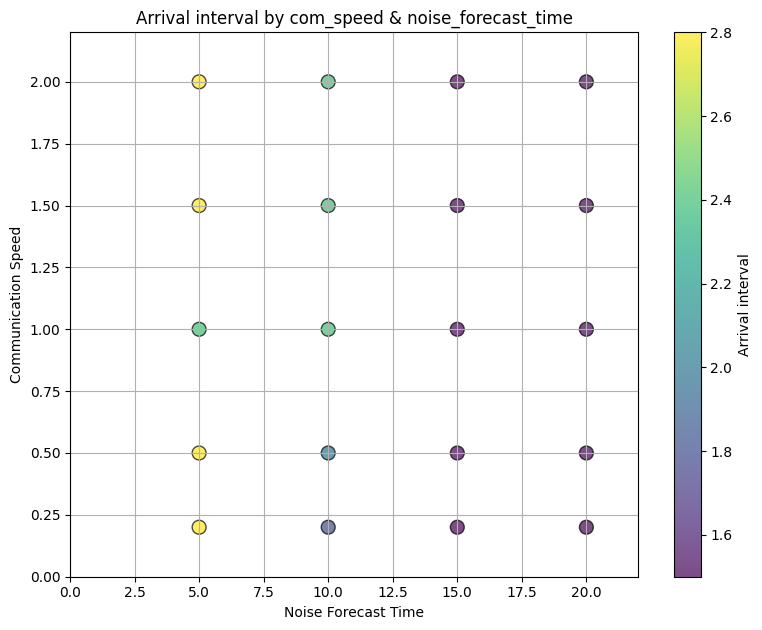

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

result_from_csv = pd.read_csv("result_df_without_v_mean.csv")

def plot_forecast_vs_speed(_df):
    # is_success が True のデータのみをフィルタリング
    successful_results = _df[(_df['is_success']) & (_df['type']=="dfr")]

    # 最小のdensityを取得するための辞書を作成
    min_density_by_forecast_and_speed = {}

    for _, row in successful_results.iterrows():
        key = (row['noise_forecast_time'], row['communication_speed'])
        if key not in min_density_by_forecast_and_speed:
            min_density_by_forecast_and_speed[key] = row['density']
        else:
            if row['density'] < min_density_by_forecast_and_speed[key]:
                min_density_by_forecast_and_speed[key] = row['density']

    # プロットの準備
    fig, ax = plt.subplots(figsize=(8, 6.4))

    # プロット用のリストを作成
    forecast_times = []
    comm_speeds = []
    min_densities = []

    for (forecast_time, comm_speed), min_density in min_density_by_forecast_and_speed.items():
        forecast_times.append(forecast_time)
        comm_speeds.append(comm_speed)
        min_densities.append(min_density)

    # 散布図をプロット
    scatter = ax.scatter(forecast_times, comm_speeds, c=min_densities, cmap='viridis', s=100, edgecolor='k', alpha=0.7)
    plt.colorbar(scatter, label='Arrival interval')

    ax.set_xlabel('Noise Forecast Time')
    ax.set_ylabel('Communication Speed')
    ax.set_title('Arrival interval by com_speed & noise_forecast_time')
    ax.grid(True)
    ax.set_ylim(0, 2.2)  # 縦軸の範囲を0から2.2までに設定
    ax.set_xlim(0, 22)  # 縦軸の範囲を0から2.2までに設定


    # グラフを表示
    plt.tight_layout()
    plt.show()

# 使用例
plot_forecast_vs_speed(result_from_csv)


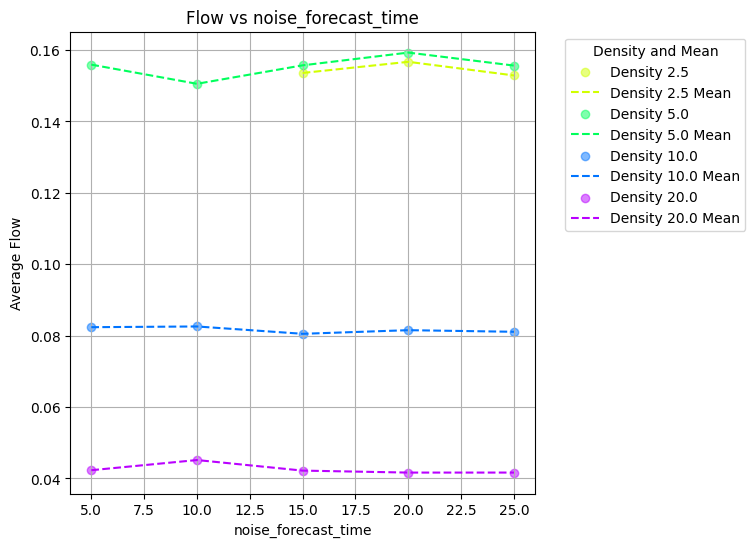

  type  density                                             v_mean  \
0  dfr     20.0  {0.002: 20.952614641995172, 0.0026666666666666...   
1  vfr     20.0  {0.0013333333333333333: 26.126724051992728, 0....   
2  dfr     10.0  {0.004: 21.10102730467694, 0.00466666666666666...   
3  vfr     10.0                                               None   
4  dfr      5.0  {0.006666666666666667: 19.879278846153845, 0.0...   

   noise_forecast_time  noise_period  communication_speed  is_success  \
0                    5             5                  0.2        True   
1                    5             5                  0.2        True   
2                    5             5                  0.2        True   
3                    5             5                  0.2        True   
4                    5             5                  0.2        True   

       flow  
0  0.047677  
1  0.046179  
2  0.084386  
3       NaN  
4  0.149299  


In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def analyze_result(result_df, axis):
    # 平均流量を計算して 'flow' 列に追加
    def calculate_mean_flow(v_mean_dict):
        if v_mean_dict:
            total_flow = sum(density * speed for density, speed in v_mean_dict.items())
            mean_flow = total_flow / len(v_mean_dict)
            return mean_flow
        else:
            return None

    # 'flow' 列を計算して追加
    result_df['flow'] = result_df['v_mean'].apply(calculate_mean_flow)

    # is_success が True のデータのみをフィルタリングし、DFRだけに絞る
    dfr_results = result_df[(result_df['is_success']) & (result_df['type'] == 'dfr')& (result_df['communication_speed'] == 2) ]
    # dfr_results = result_df[(result_df['type'] == 'dfr') & (result_df['noise_forecast_time'] == 15)]

    grouped = dfr_results.groupby('density')


    # プロット
    plt.figure(figsize=(6, 6))
    colors = sns.color_palette("hsv", len(grouped))  # 密度ごとの色を指定
    for (density, group), color in zip(grouped, colors):
        plt.scatter(group[axis], group['flow'], color=color, alpha=0.5, label=f'Density {density}')
        mean_flow = group.groupby(axis)['flow'].mean()
        plt.plot(mean_flow.index, mean_flow.values, color=color, linestyle='--', label=f'Density {density} Mean')

    
    plt.xlabel(axis)
    plt.ylabel('Average Flow')
    plt.title(f'Flow vs {axis}')
    plt.grid(True)
    plt.legend(title="Density and Mean", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()
    return result_df

# 使い方の例:
# analyze_result(result_df, 'density')
df = analyze_result(result_df, 'noise_forecast_time')
print(df.head())


In [28]:
print(df.head)

  type  density                                             v_mean  \
0  dfr       20  {0.002: 21.41955223880597, 0.00266666666666666...   
1  vfr       20  {0.0013333333333333333: 28.910429369581912, 0....   
2  dfr       18  {0.0026666666666666666: 20.642469376391983, 0....   
3  vfr       18  {0.002: 25.540685351784756, 0.0013333333333333...   
4  dfr       20  {0.002: 21.067838827838827, 0.0026666666666666...   

   noise_forecast_time  noise_period  communication_speed  is_success  \
0                    5             5                  0.2        True   
1                    5             5                  0.2        True   
2                    5             5                  0.2        True   
3                    5             5                  0.2        True   
4                    5             5                  1.0        True   

       flow  
0  0.042264  
1  0.046762  
2  0.056597  
3  0.051449  
4  0.042102  


In [6]:
sys.stdout = original_stdout
vfr_simulation.conduct_simulation(should_plot=False)

Simulation Progress VFR:   0%|          | 0/3000 [00:00<?, ?it/s]

t=1.0, event_flg=arrival, noise=[]
t=10.0, event_flg=noise created, noise=[{'x': [420, 450], 't': [20.0, 25.0]}]
t=22.5, event_flg=arrival, noise=[{'x': [420, 450], 't': [20.0, 25.0]}]
t=30.0, event_flg=noise created, noise=[{'x': [420, 450], 't': [40.0, 45.0]}]
t=43.6, event_flg=arrival, noise=[{'x': [420, 450], 't': [40.0, 45.0]}]
t=50.0, event_flg=noise created, noise=[{'x': [420, 450], 't': [60.0, 65.0]}]
t=65.60000000000001, event_flg=arrival, noise=[]
t=70.0, event_flg=noise created, noise=[{'x': [420, 450], 't': [80.0, 85.0]}]
t=87.5, event_flg=arrival, noise=[]
t=90.0, event_flg=noise created, noise=[{'x': [420, 450], 't': [100.0, 105.0]}]
t=108.4, event_flg=arrival, noise=[]
t=110.0, event_flg=noise created, noise=[{'x': [420, 450], 't': [120.0, 125.0]}]
t=130.0, event_flg=noise created, noise=[{'x': [420, 450], 't': [140.0, 145.0]}]
t=130.6, event_flg=arrival, noise=[{'x': [420, 450], 't': [140.0, 145.0]}]
t=150.0, event_flg=noise created, noise=[{'x': [420, 450], 't': [160.0

In [6]:
# vfr_simulation.v_mean_log

In [12]:
# デバッグ用
cars = vfr_simulation.CARS
arrival_time = [car.arrival_time for car in cars ]
print(a)

[1.5747913067572927, 21.884781546599264, 43.57761751901193, 65.72947032936375, 87.71481304428235, 108.38870119472111, 128.66775903669526, 149.6319143917426, 169.8496563382233, 191.29332540198297, 212.20566913719142, 233.5853557619162, 254.21237695967878, 276.0895799103375, 296.70981143152346, 318.1552792239881, 339.79017486821664, 360.1846053681384, 380.8997579179795, 401.1219338621628, 401.7]


In [8]:
print(results)

[{'type': 'dfr', 'density': 20, 'v_mean': {0.012666666666666666: 20.777138157894736, 0.012: 20.555555555555557, 0.011333333333333334: 20.0, 0.010666666666666666: 20.0, 0.01: 20.0, 0.009333333333333334: 20.0, 0.008666666666666666: 20.0, 0.008: 20.0, 0.007333333333333333: 20.0, 0.006666666666666667: 20.025675675675675, 0.006: 20.766666666666666, 0.005333333333333333: 22.003345070422533, 0.004666666666666667: 23.428571428571427, 0.004: 23.47685185185185, 0.0033333333333333335: 23.6, 0.0026666666666666666: 22.25}}, {'type': 'vfr', 'density': 20, 'v_mean': {0.014: 8.984284216831387}}, {'type': 'dfr', 'density': 18, 'v_mean': {0.014: 20.857142857142858, 0.013333333333333334: 20.45, 0.012666666666666666: 20.0, 0.012: 20.0, 0.011333333333333334: 20.0, 0.010666666666666666: 20.0, 0.01: 20.0, 0.009333333333333334: 20.0, 0.008666666666666666: 20.0, 0.008: 20.0, 0.007333333333333333: 20.0, 0.006666666666666667: 20.0, 0.006: 20.0, 0.005333333333333333: 20.0, 0.004666666666666667: 20.0, 0.004: 20.0}

In [35]:
# print(arrival_time_log)

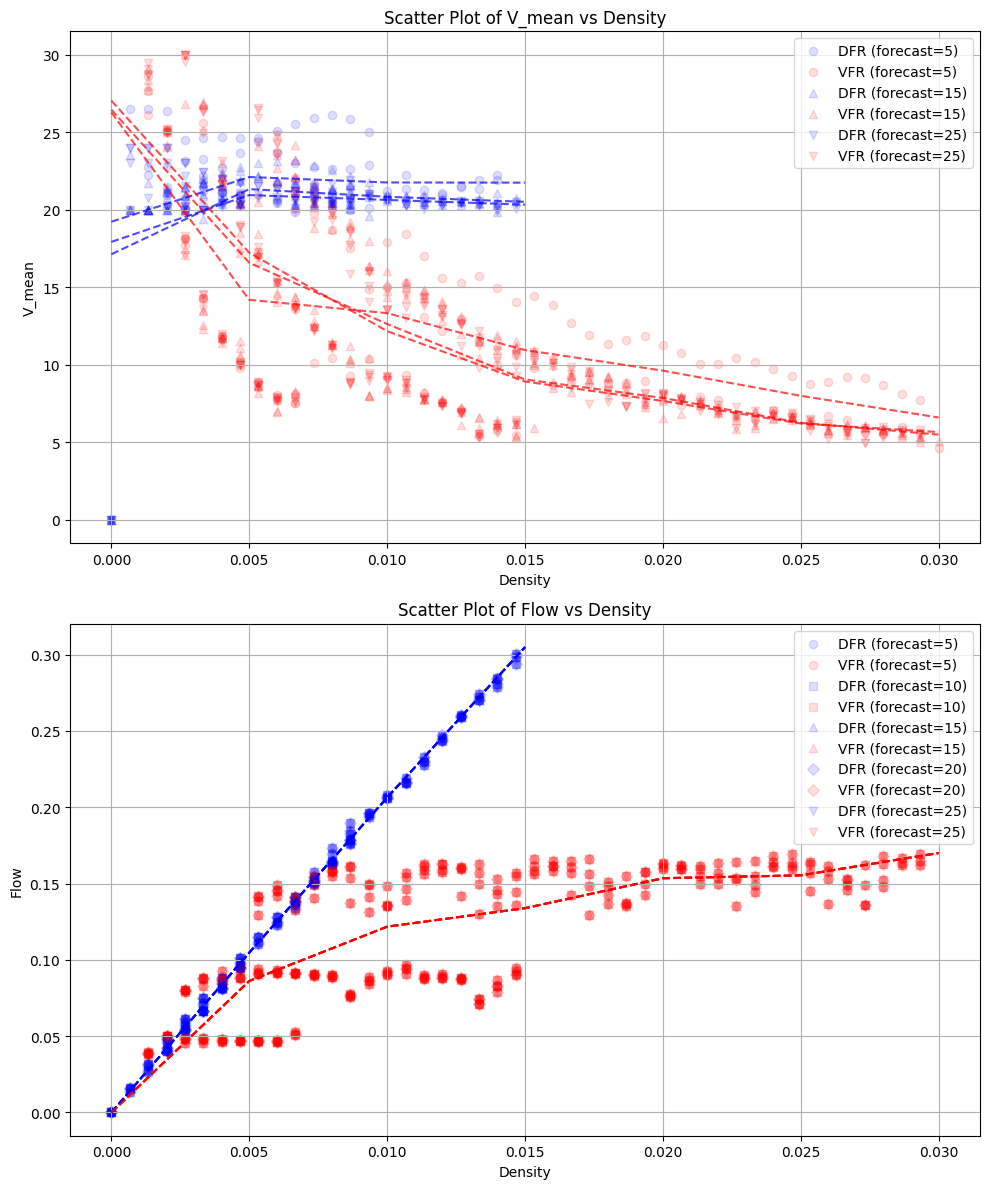

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_result(result_df):
    # is_success が True のデータのみをフィルタリング
    successful_results = result_df[result_df['is_success']]

    # noise_forecast_timeごとにデータを分ける
    noise_forecast_times = sorted(successful_results['noise_forecast_time'].unique())
    
    # マーカーの種類を指定
    markers = ['o', 's', '^', 'D', 'v']
    colors = ['blue', 'red']  # DFRとVFRで色を分ける

    # プロットの準備
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))

    for idx, noise_forecast_time in enumerate(noise_forecast_times):
        if noise_forecast_time in [10, 20]:
            continue
        dfr_data = {'density': [], 'v_mean': [], 'flow': []}
        vfr_data = {'density': [], 'v_mean': [], 'flow': []}

        # 各densityに対するv_meanの平均を計算するための辞書
        dfr_density_v_mean = defaultdict(list)
        vfr_density_v_mean = defaultdict(list)

        # noise_forecast_timeごとにフィルタリング
        filtered_results = successful_results[successful_results['noise_forecast_time'] == noise_forecast_time]

        for entry in filtered_results.to_dict(orient='records'):
            if entry['v_mean'] is not None:
                for density, v_mean in entry['v_mean'].items():
                    if entry['type'] == 'dfr':
                        dfr_data['density'].append(density)
                        dfr_data['v_mean'].append(v_mean)
                        dfr_data['flow'].append(density * v_mean)
                        dfr_density_v_mean[density].append(v_mean)
                    elif entry['type'] == 'vfr':
                        vfr_data['density'].append(density)
                        vfr_data['v_mean'].append(v_mean)
                        vfr_data['flow'].append(density * v_mean)
                        vfr_density_v_mean[density].append(v_mean)

        plot_densities = np.arange(0.00, 0.055, 0.005)

        def calculate_avg_per_density_interval(density_v_mean_dict, plot_densities):
            density_avg_v_mean = {}
            density_avg_flow = {}

            for target_density in plot_densities:
                lower_bound = target_density - 0.0025
                upper_bound = target_density + 0.0025

                # 密度範囲に入るデータをフィルタリング
                v_means_in_range = [v_mean for density, v_mean_list in density_v_mean_dict.items()
                                    if lower_bound < density <= upper_bound
                                    for v_mean in v_mean_list]

                if v_means_in_range:
                    avg_v_mean = np.mean(v_means_in_range)
                    density_avg_v_mean[target_density] = avg_v_mean
                    density_avg_flow[target_density] = target_density * avg_v_mean

            return density_avg_v_mean, density_avg_flow

        # DFRとVFRの平均計算
        dfr_density_avg_v_mean, dfr_density_avg_flow = calculate_avg_per_density_interval(dfr_density_v_mean, plot_densities)
        vfr_density_avg_v_mean, vfr_density_avg_flow = calculate_avg_per_density_interval(vfr_density_v_mean, plot_densities)

        # ソートしてリスト化
        dfr_density_sorted_v_mean = sorted(dfr_density_avg_v_mean.items())
        vfr_density_sorted_v_mean = sorted(vfr_density_avg_v_mean.items())

        dfr_density_sorted_flow = sorted(dfr_density_avg_flow.items())
        vfr_density_sorted_flow = sorted(vfr_density_avg_flow.items())

        # v_mean vs density
        axs[0].scatter(dfr_data['density'], dfr_data['v_mean'], color=colors[0], marker=markers[idx], label=f'DFR (forecast={noise_forecast_time})', alpha=0.13)
        axs[0].scatter(vfr_data['density'], vfr_data['v_mean'], color=colors[1], marker=markers[idx], label=f'VFR (forecast={noise_forecast_time})', alpha=0.13)

        # 平均線を引く
        axs[0].plot([item[0] for item in dfr_density_sorted_v_mean], [item[1] for item in dfr_density_sorted_v_mean], color=colors[0], linestyle='--', alpha=0.7)
        axs[0].plot([item[0] for item in vfr_density_sorted_v_mean], [item[1] for item in vfr_density_sorted_v_mean], color=colors[1], linestyle='--', alpha=0.7)

    axs[0].set_xlabel('Density')
    axs[0].set_ylabel('V_mean')
    axs[0].set_title('Scatter Plot of V_mean vs Density')
    axs[0].legend()
    axs[0].grid(True)

    for idx, noise_forecast_time in enumerate(noise_forecast_times):
        # flow vs density
        axs[1].scatter(dfr_data['density'], dfr_data['flow'], color=colors[0], marker=markers[idx], label=f'DFR (forecast={noise_forecast_time})', alpha=0.13)
        axs[1].scatter(vfr_data['density'], vfr_data['flow'], color=colors[1], marker=markers[idx], label=f'VFR (forecast={noise_forecast_time})', alpha=0.13)

        # 平均線を引く
        axs[1].plot([item[0] for item in dfr_density_sorted_flow], [item[1] for item in dfr_density_sorted_flow], color=colors[0], linestyle='--', alpha=0.7)
        axs[1].plot([item[0] for item in vfr_density_sorted_flow], [item[1] for item in vfr_density_sorted_flow], color=colors[1], linestyle='--', alpha=0.7)

    axs[1].set_xlabel('Density')
    axs[1].set_ylabel('Flow')
    axs[1].set_title('Scatter Plot of Flow vs Density')
    axs[1].legend()
    axs[1].grid(True)

    # グラフを表示
    plt.tight_layout()
    plt.savefig(f"./images/test_df_combined_totalTime={TOTAL_TIME}.png")
    plt.show()

# 使用例
plot_result(result_df)


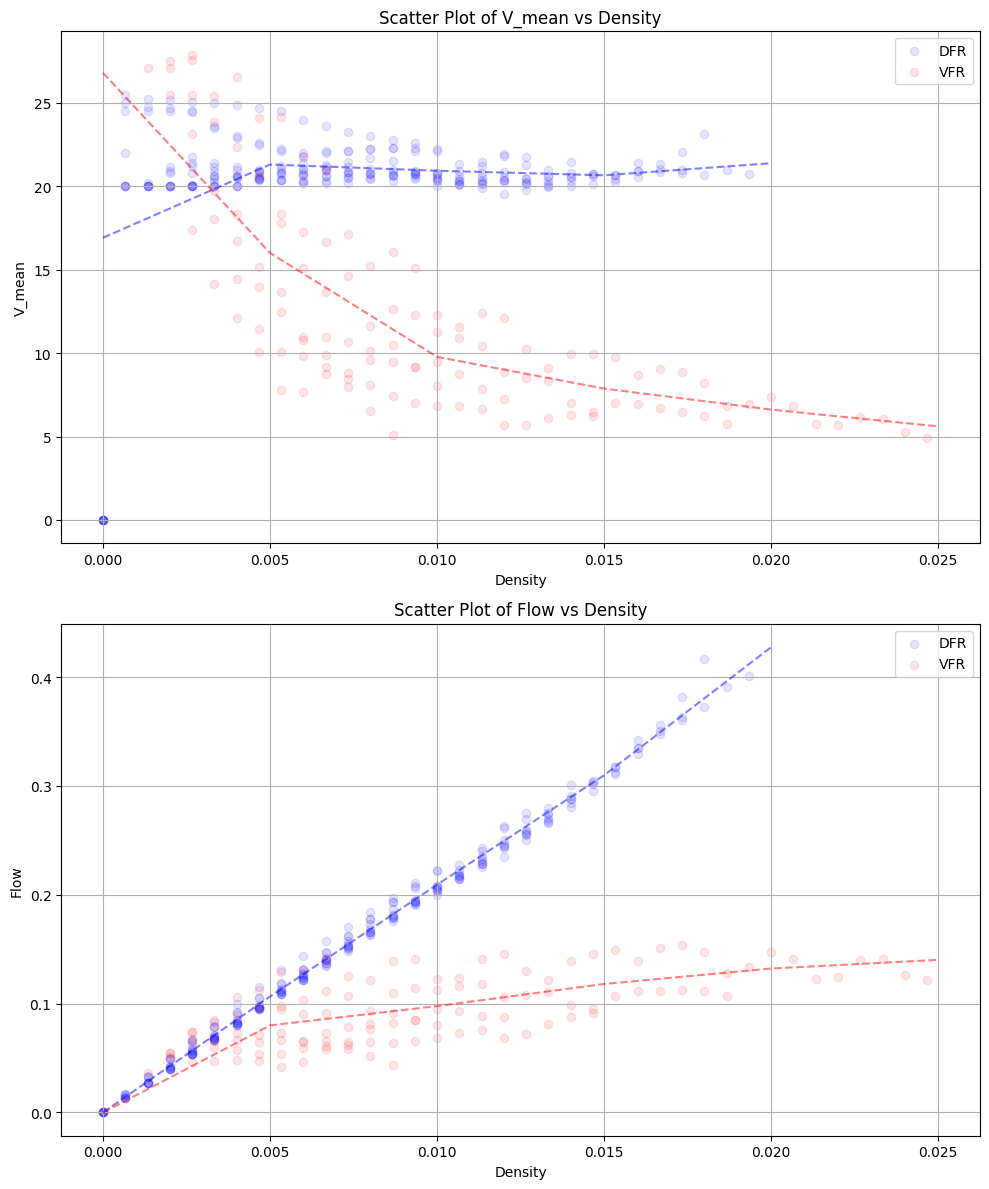

In [19]:
# result_dfではなくresultオブジェクトを使ったもの

dfr_data = {'density': [], 'v_mean': [], 'flow': []}
vfr_data = {'density': [], 'v_mean': [], 'flow': []}

# 各densityに対するv_meanの平均を計算するための辞書
dfr_density_v_mean = defaultdict(list)
vfr_density_v_mean = defaultdict(list)

for entry in results:
    if entry['v_mean'] is not None:
        for density, v_mean in entry['v_mean'].items():
            if entry['type'] == 'dfr':
                dfr_data['density'].append(density)
                dfr_data['v_mean'].append(v_mean)
                dfr_data['flow'].append(density * v_mean)
                dfr_density_v_mean[density].append(v_mean)
            elif entry['type'] == 'vfr':
                vfr_data['density'].append(density)
                vfr_data['v_mean'].append(v_mean)
                vfr_data['flow'].append(density * v_mean)
                vfr_density_v_mean[density].append(v_mean)

plot_densities = np.arange(0.00, 0.055, 0.005)

def calculate_avg_per_density_interval(density_v_mean_dict, plot_densities):
    density_avg_v_mean = {}
    density_avg_flow = {}

    for target_density in plot_densities:
        lower_bound = target_density - 0.0025
        upper_bound = target_density + 0.0025
        
        # 密度範囲に入るデータをフィルタリング
        v_means_in_range = [v_mean for density, v_mean_list in density_v_mean_dict.items()
                            if lower_bound < density <= upper_bound
                            for v_mean in v_mean_list]
        
        if v_means_in_range:
            avg_v_mean = np.mean(v_means_in_range)
            density_avg_v_mean[target_density] = avg_v_mean
            density_avg_flow[target_density] = target_density * avg_v_mean

    return density_avg_v_mean, density_avg_flow


# DFRとVFRの平均計算
dfr_density_avg_v_mean, dfr_density_avg_flow = calculate_avg_per_density_interval(dfr_density_v_mean, plot_densities)
vfr_density_avg_v_mean, vfr_density_avg_flow = calculate_avg_per_density_interval(vfr_density_v_mean, plot_densities)


# ソートしてリスト化
dfr_density_sorted_v_mean = sorted(dfr_density_avg_v_mean.items())
vfr_density_sorted_v_mean = sorted(vfr_density_avg_v_mean.items())

dfr_density_sorted_flow = sorted(dfr_density_avg_flow.items())
vfr_density_sorted_flow = sorted(vfr_density_avg_flow.items())

# プロット
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# v_mean vs density
axs[0].scatter(dfr_data['density'], dfr_data['v_mean'], color='blue', label='DFR', alpha=0.1)
axs[0].scatter(vfr_data['density'], vfr_data['v_mean'], color='red', label='VFR', alpha=0.1)

# 平均線を引く
axs[0].plot([item[0] for item in dfr_density_sorted_v_mean], [item[1] for item in dfr_density_sorted_v_mean], color='blue', linestyle='--', alpha=0.5)
axs[0].plot([item[0] for item in vfr_density_sorted_v_mean], [item[1] for item in vfr_density_sorted_v_mean], color='red', linestyle='--', alpha=0.5)

axs[0].set_xlabel('Density')
axs[0].set_ylabel('V_mean')
axs[0].set_title('Scatter Plot of V_mean vs Density')
axs[0].legend()
axs[0].grid(True)

# flow vs density
axs[1].scatter(dfr_data['density'], dfr_data['flow'], color='blue', label='DFR', alpha=0.1)
axs[1].scatter(vfr_data['density'], vfr_data['flow'], color='red', label='VFR', alpha=0.1)

# 平均線を引く
axs[1].plot([item[0] for item in dfr_density_sorted_flow], [item[1] for item in dfr_density_sorted_flow], color='blue', linestyle='--', alpha=0.5)
axs[1].plot([item[0] for item in vfr_density_sorted_flow], [item[1] for item in vfr_density_sorted_flow], color='red', linestyle='--', alpha=0.5)


axs[1].set_xlabel('Density')
axs[1].set_ylabel('Flow')
axs[1].set_title('Scatter Plot of Flow vs Density')
axs[1].legend()
axs[1].grid(True)

# グラフを表示
plt.tight_layout()
plt.savefig(f"./images/n_period={NOISE_PERIOD}_n_forecast={NOISE_FORECAST_TIME}_n_freq={NOISE_FREQUENCY}_totalTime={TOTAL_TIME}.png")
plt.show()


In [16]:
vlog = simulation.v_mean_log
print(vlog[300:340])
table = simulation.reservation_table.eta_table
print(table[table["car_idx"] == 0])

[{'time': 33.0, 'v_mean': 20.04736842105263, 'density': 0.019, 'event_flg': None}, {'time': 33.1, 'v_mean': 20.031578947368423, 'density': 0.019, 'event_flg': None}, {'time': 33.2, 'v_mean': 20.01578947368421, 'density': 0.019, 'event_flg': None}, {'time': 33.300000000000004, 'v_mean': 20.0, 'density': 0.019, 'event_flg': None}, {'time': 33.4, 'v_mean': 19.98421052631579, 'density': 0.019, 'event_flg': None}, {'time': 33.5, 'v_mean': 19.968421052631577, 'density': 0.019, 'event_flg': None}, {'time': 33.6, 'v_mean': 19.95263157894737, 'density': 0.019, 'event_flg': None}, {'time': 33.7, 'v_mean': 19.936842105263157, 'density': 0.019, 'event_flg': None}, {'time': 33.800000000000004, 'v_mean': 19.92105263157895, 'density': 0.019, 'event_flg': None}, {'time': 33.9, 'v_mean': 19.905263157894737, 'density': 0.019, 'event_flg': None}, {'time': 34.0, 'v_mean': 19.905263157894737, 'density': 0.019, 'event_flg': None}, {'time': 34.1, 'v_mean': 19.905263157894737, 'density': 0.019, 'event_flg': N

[20.300000000000004, 20.599999999999994, 20.9, 21.20000000000001, 21.500000000000004, 21.800000000000015, 22.10000000000001, 22.40000000000002, 22.699999999999996, 23.000000000000007, 23.30000000000002, 23.599999999999994, 23.900000000000006, 24.200000000000017, 24.499999999999993, 24.80000000000004, 24.933763884510753, 25.00205455537177, 25.045066351248195, 25.078284478181345, 25.107649150798323, 25.13543427568102, 25.162509497197192, 25.189207542893186, 25.21565612084416, 25.241904739377077, 25.26797310634123, 25.29386957926704, 25.319598191088915, 25.34516132271463, 25.37056071867525, 25.39579787278342, 25.420874174509436, 25.44579096457028, 25.470549556103492, 25.49515124281058, 25.51959730216808, 25.54388899677207, 25.568027574976497, 25.592014271262684, 25.615850306503347, 25.639536888187706, 25.66307521062626, 25.686466455148178, 25.709711790291863, 25.73281237199282, 26.032812371992833, 26.332812371992844, 26.632812371992856, 26.932812371992867, 27.23281237199288, 27.5328123719

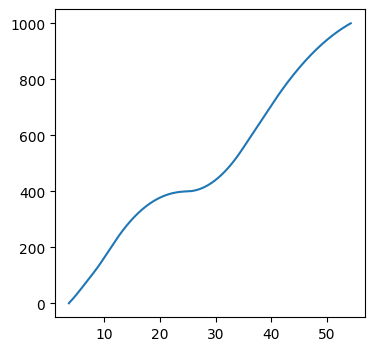

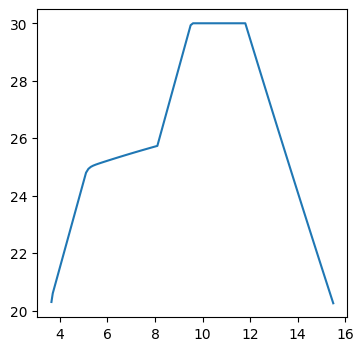

In [15]:
cars = vfr_simulation.CARS
car_0 = cars[1]
xcors = car_0.xcorList
plt.figure(figsize = (4,4))
plt.plot(car_0.timeLog, car_0.xcorList)

vList = []
for i in range(len(xcors)-1):
    v = (xcors[i+1] - xcors[i]) * 10
    vList.append(v)

print(vList[:120])

plt.figure(figsize=(4,4))
plt.plot(car_0.timeLog[:120], vList[:120])



In [14]:
# 動画作成
import cv2
import os
import re

# カレントディレクトリを取得
current_dir = os.getcwd()
# 画像フォルダのパス
image_folder = os.path.join(current_dir, 'images/dfr/example_0927/共有用')
video_file = f'test.mp4'

# 正規表現でファイル名からtの値を抽出
def extract_t(filename):
    match = re.search(r't=(\d+\.\d+)', filename)
    if match:
        return float(match.group(1))
    return None

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
images = sorted(images, key=lambda x: extract_t(x))

# 画像から動画を作成
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

# 動画ライターを設定
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter(video_file, fourcc, 5, (width, height))  # フレームレートを5fpsに設定

for image in images:
    print(image)
    video.write(cv2.imread(os.path.join(image_folder, image)))

# リソースを解放
cv2.destroyAllWindows()
video.release()

dfr_simulation_t=2.5.png
dfr_simulation_t=3.0.png
dfr_simulation_t=3.5.png
dfr_simulation_t=4.0.png
dfr_simulation_t=4.5.png
dfr_simulation_t=5.0.png
dfr_simulation_t=5.5.png
dfr_simulation_t=6.0.png
dfr_simulation_t=6.4.png
dfr_simulation_t=6.5.png
dfr_simulation_t=7.0.png
dfr_simulation_t=7.5.png
dfr_simulation_t=8.0.png
dfr_simulation_t=8.5.png
dfr_simulation_t=9.0.png
dfr_simulation_t=9.5.png
dfr_simulation_t=10.0.png
dfr_simulation_t=10.5.png
dfr_simulation_t=11.0.png
dfr_simulation_t=11.5.png
dfr_simulation_t=12.0.png
dfr_simulation_t=12.5.png
dfr_simulation_t=13.0.png
dfr_simulation_t=13.5.png
dfr_simulation_t=13.8.png
dfr_simulation_t=14.0.png
dfr_simulation_t=14.5.png
dfr_simulation_t=15.0.png
dfr_simulation_t=15.5.png
dfr_simulation_t=16.0.png
dfr_simulation_t=16.5.png
dfr_simulation_t=17.0.png
dfr_simulation_t=17.5.png
dfr_simulation_t=18.0.png
dfr_simulation_t=18.5.png
dfr_simulation_t=19.0.png
dfr_simulation_t=19.4.png
dfr_simulation_t=19.5.png
dfr_simulation_t=20.0.png
df

# ここから下はDebug用のセル

In [27]:
# ↑の DFRのシミュレーションでつっかえた時のデバッグ用のセル. これは適宜上に上げて良い

car_1 = CARS[14]
print("ETA",car_1.my_etas)
print("===  acc_itinerary =====")
print(car_1.acc_itinerary)
print(car_1.xcor)
print(car_1.v_x)

# print("acc:",car.acc_itinerary)
# table = simulation.reservation_table.eta_table
# print(table[table["car_idx"]<=4])

IndexError: list index out of range

In [7]:
import sys 
sys.path.append("../")
from utils.calc_distance_from_acc_itinerary import calc_distance_from_acc_itinerary
acc_itinerary = [{'acc': 0, 't_start': 29.113823476836664, 'v_0': 20, 't_end': 32.6, 'x_start': 0}, {'t_start': 32.6, 'acc': -3, 'v_0': 20.0, 't_end': 33.1}, {'t_start': 33.1, 'acc': 0, 'v_0': 18.5, 't_end': 45.120270270270275}, {'t_start': 45.120270270270275, 'acc': -3, 'v_0': 18.5, 't_end': 45.620270270270275}, {'t_start': 45.620270270270275, 'acc': 0, 'v_0': 17.0, 't_end': 52.745270270270275}, {'t_start': 52.745270270270275, 'acc': 2, 'v_0': 17.0, 't_end': 53.745270270270275}, {'t_start': 53.745270270270275, 'acc': 0, 'v_0': 19.0, 't_end': 56.804093799682036}, {'t_start': 56.804093799682036, 'acc': 2, 'v_0': 19.0, 't_end': 60.804093799682036}, {'t_start': 60.804093799682036, 'acc': 0, 'v_0': 27.0, 't_end': 60.90316500711238}]
x = calc_distance_from_acc_itinerary(acc_itinerary, 53)
print(x)

436.1188231038803


In [6]:
def calc_x_at_pointed_time(pointed_time, carObj, current_time):
    acc_itinerary = carObj.acc_itinerary
    car_x = carObj.xcor
    # print(carObj.xcor, carObj.acc_itinerary)
    v_0 = carObj.v_x
    acc_itinerary_with_tend = carObj.acc_itinerary
    # print(f"carId: {carObj.car_idx}, acc_itinerary: {acc_itinerary_with_tend}")

    if len(acc_itinerary_with_tend) < 1:
        raise ValueError("acc_itinerary is empty")
    if len(acc_itinerary_with_tend) == 1:
        delta_t = pointed_time - current_time
        delta_x = v_0 * delta_t + 0.5 * acc_itinerary_with_tend[0]["acc"] * delta_t**2 + car_x
        return delta_x
    
    # 長さ2以上の場合
    for idx, accObj in enumerate(acc_itinerary_with_tend):
        if accObj["t_end"] < current_time:
            continue

        # この区間を全うできる場合.
        elif accObj["t_end"] <= pointed_time:
            delta_t = accObj["t_end"] - accObj["t_start"]
            if accObj["t_start"] < current_time:
                delta_t = accObj["t_end"] - current_time
            delta_x = v_0 * delta_t + 0.5 * accObj["acc"] * delta_t**2
            car_x += delta_x
            v_0 += delta_t * accObj["acc"]

        # 一番最後の区間の場合
        elif idx == len(acc_itinerary) - 1 or accObj["t_end"] > pointed_time:
            delta_t = pointed_time - accObj["t_start"]
            if accObj["t_start"] < current_time:
                delta_t = accObj["t_end"] - current_time
            delta_x = v_0 * delta_t + 0.5 * accObj["acc"] * delta_t**2
            car_x += delta_x
            break
        else:
            print(accObj, current_time, pointed_time, carObj.car_idx)
            raise ValueError("Something wrong")

    return car_x

calc_x_at_pointed_time(53, car_1, 48)

442.42488723520705